# Analyze View 1

Loading log...
Building summary table...
                model                          dataset     score  accuracy  \
0    55_bmodel13.onnx  manager/dataset/csv_class/AKIEC  0.566994      0.78   
1    50_bmodel12.onnx  manager/dataset/csv_class/AKIEC  0.576845      0.74   
2    16_bmodel01.onnx  manager/dataset/csv_class/AKIEC  0.546214      0.78   
3   220_nmodel16.onnx  manager/dataset/csv_class/AKIEC  0.565921      0.76   
4     61_model08.onnx  manager/dataset/csv_class/AKIEC  0.540831      0.72   
..                ...                              ...       ...       ...   
75  231_model138.onnx  manager/dataset/csv_class/SCCKA  0.541250      0.74   
76    40_model96.onnx  manager/dataset/csv_class/SCCKA  0.553532      0.78   
77   18_model118.onnx  manager/dataset/csv_class/SCCKA  0.568414      0.80   
78  122_model123.onnx  manager/dataset/csv_class/SCCKA  0.504834      0.76   
79    62_model94.onnx  manager/dataset/csv_class/SCCKA  0.611830      0.84   

    precision  recall 

/tmp/ipykernel_1192874/1347137725.py:112: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


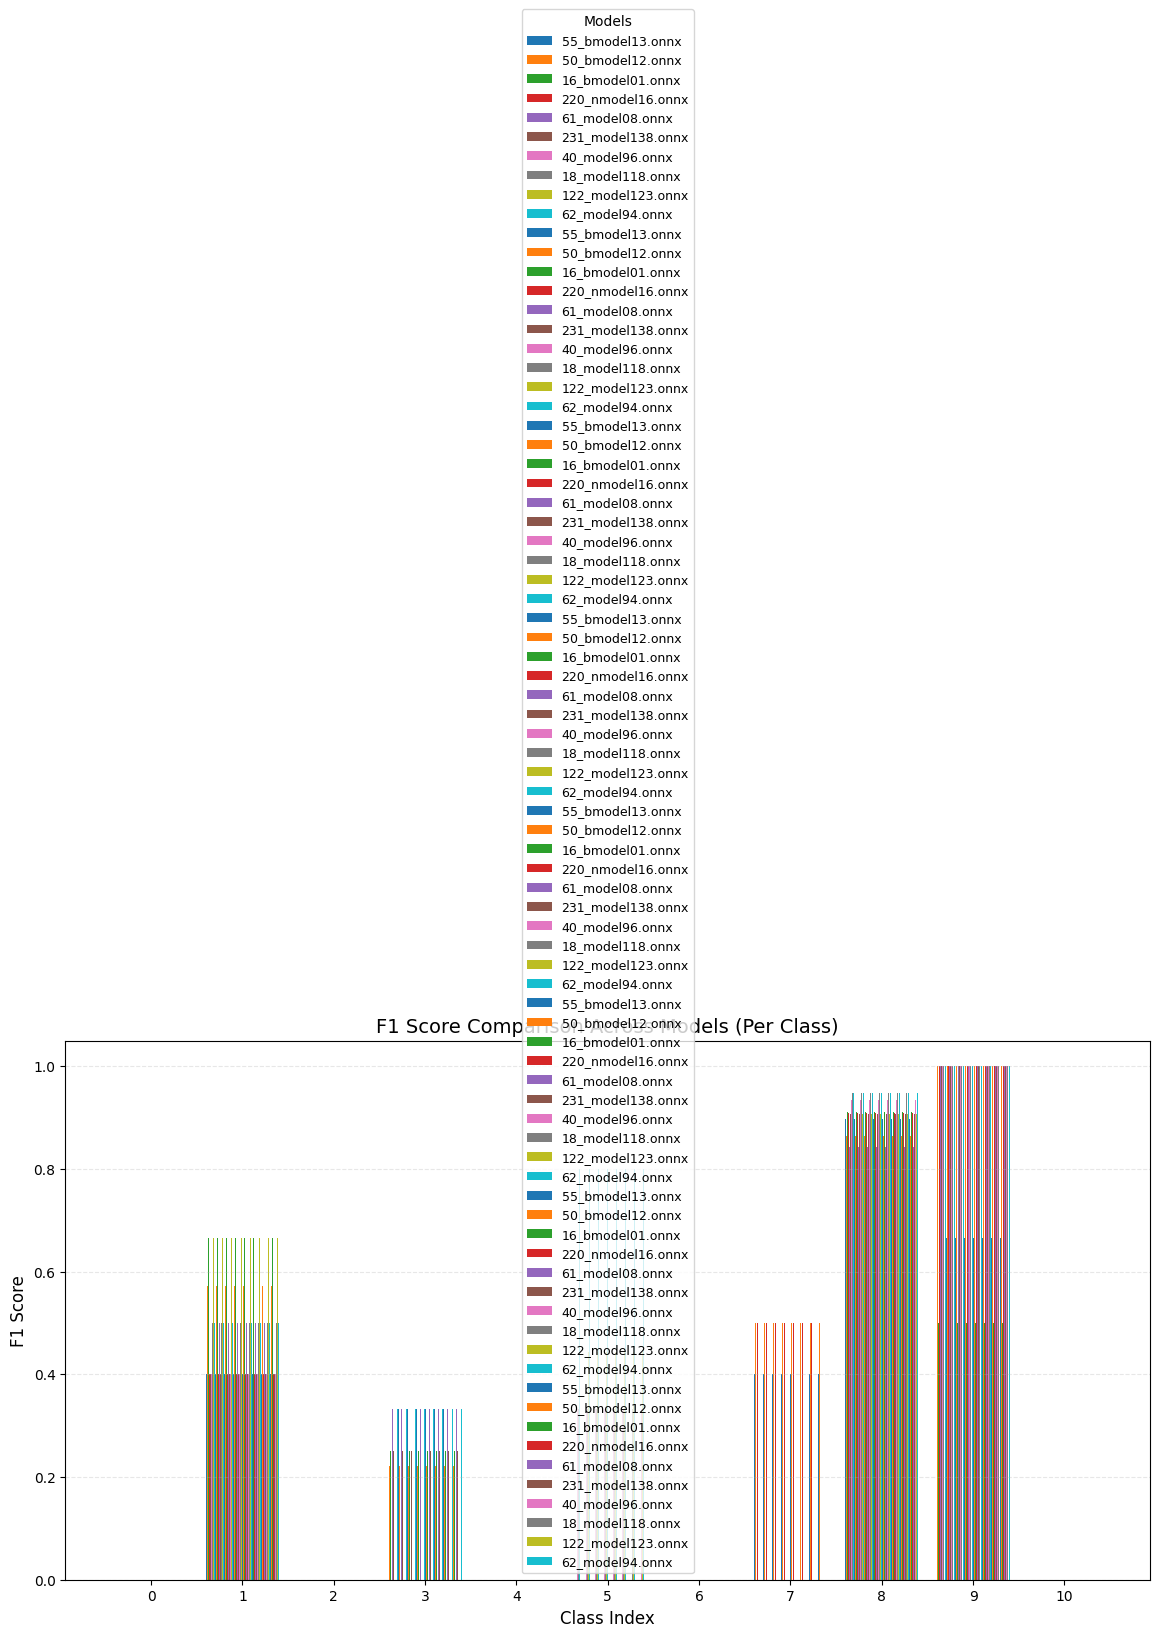

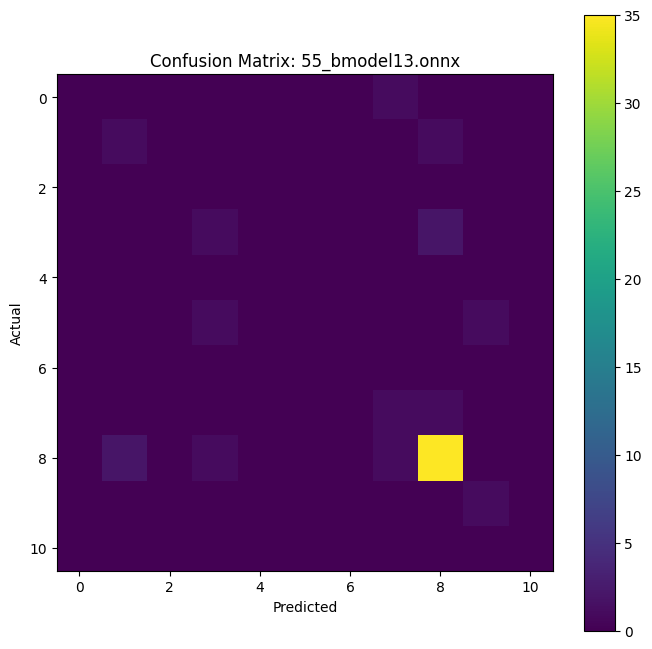

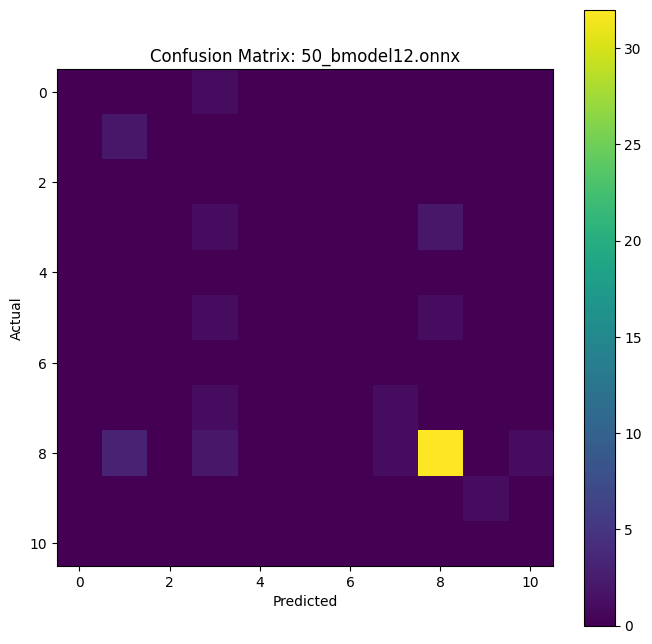

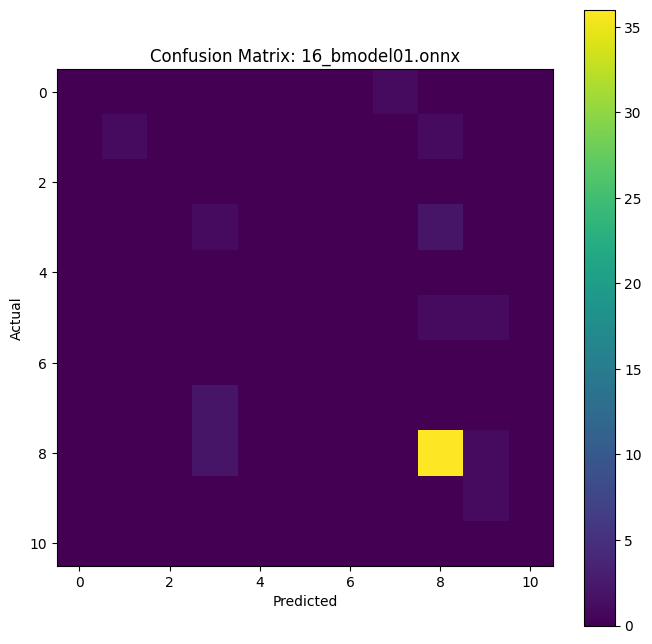

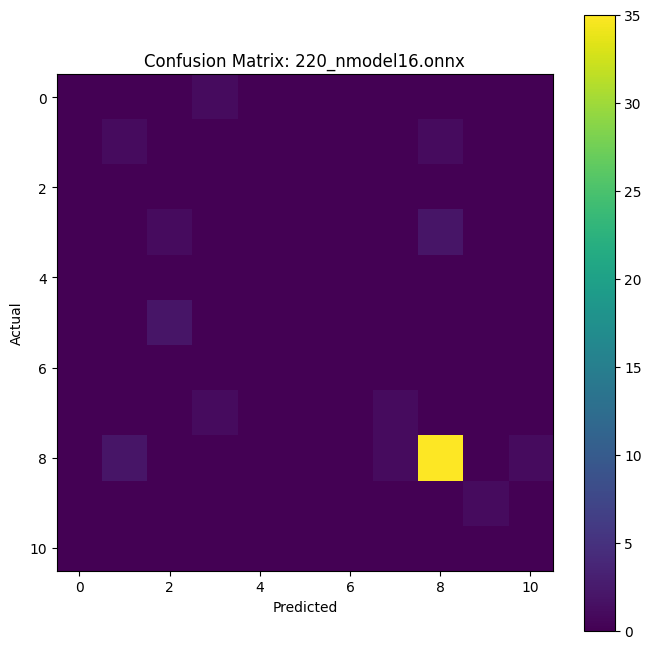

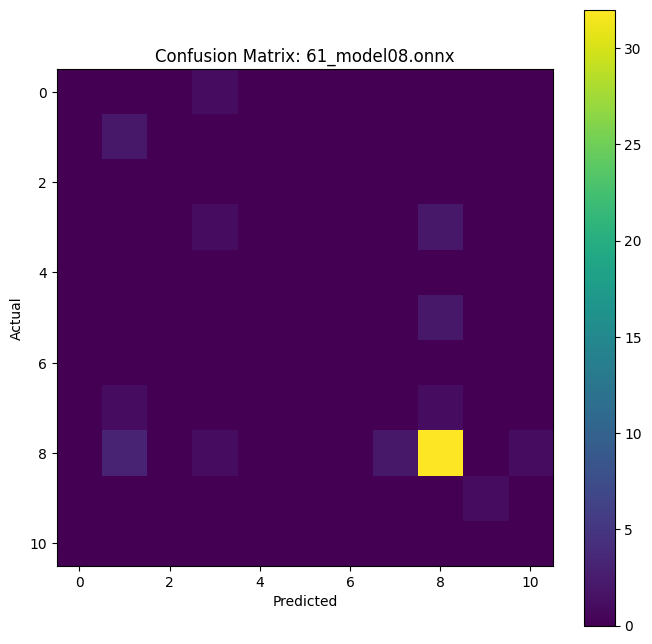

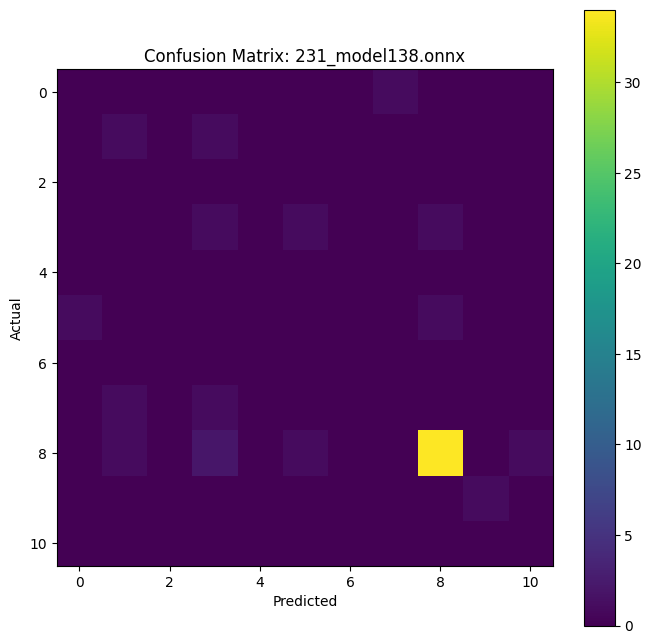

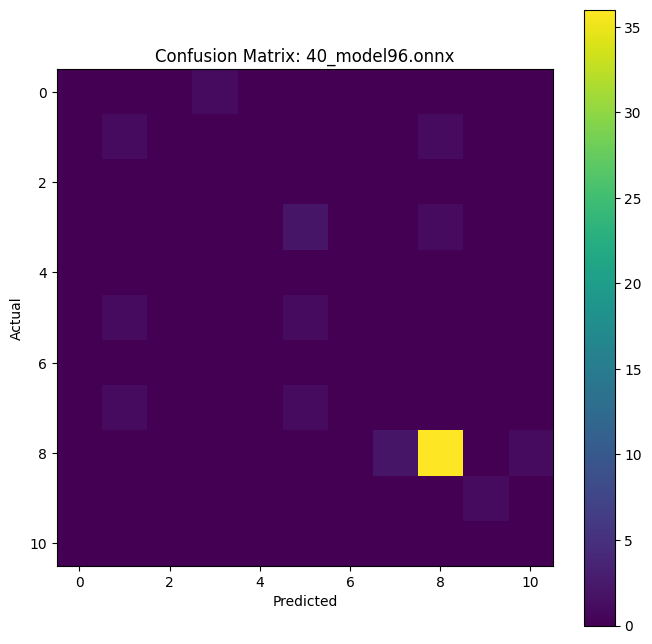

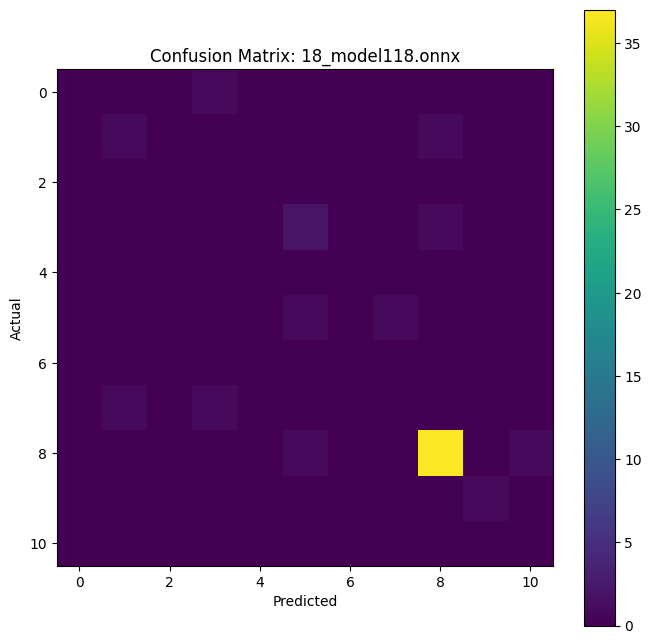

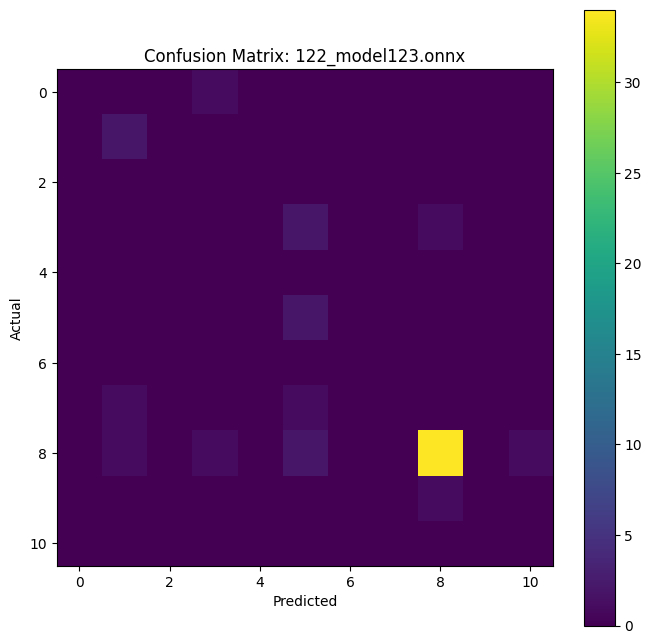

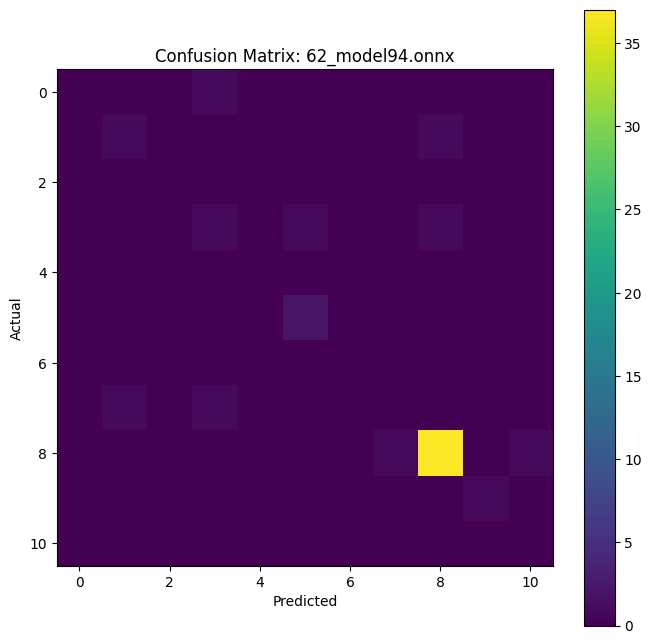

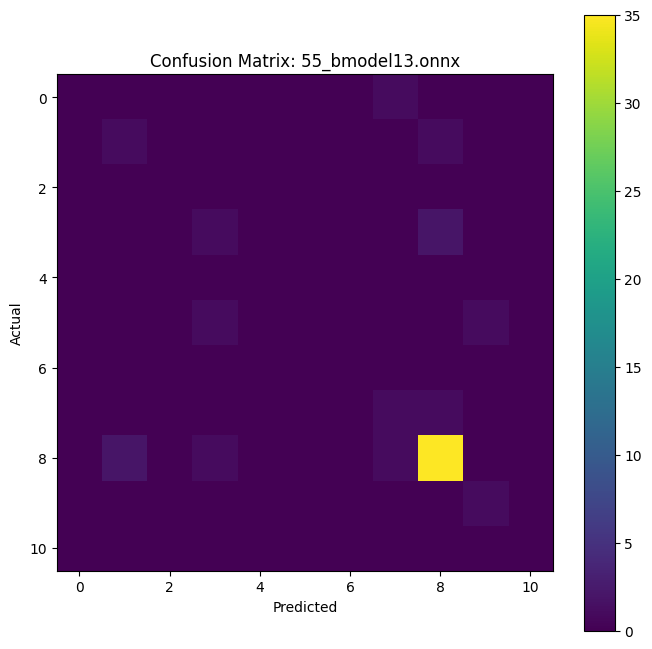

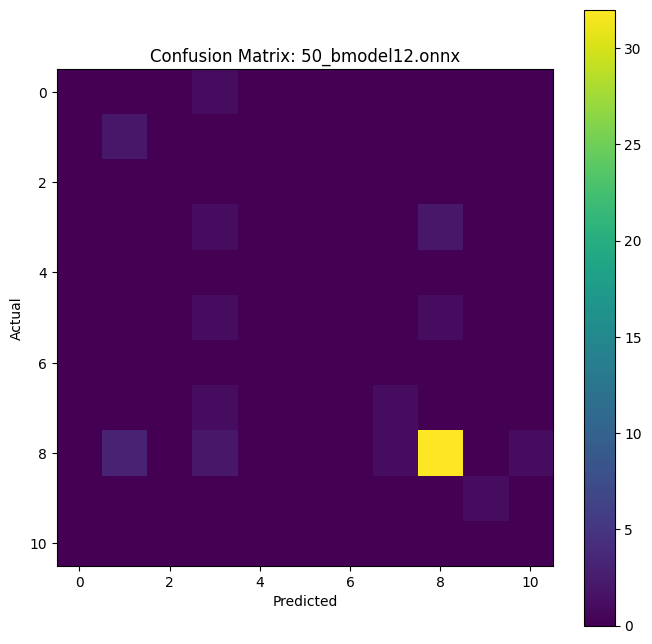

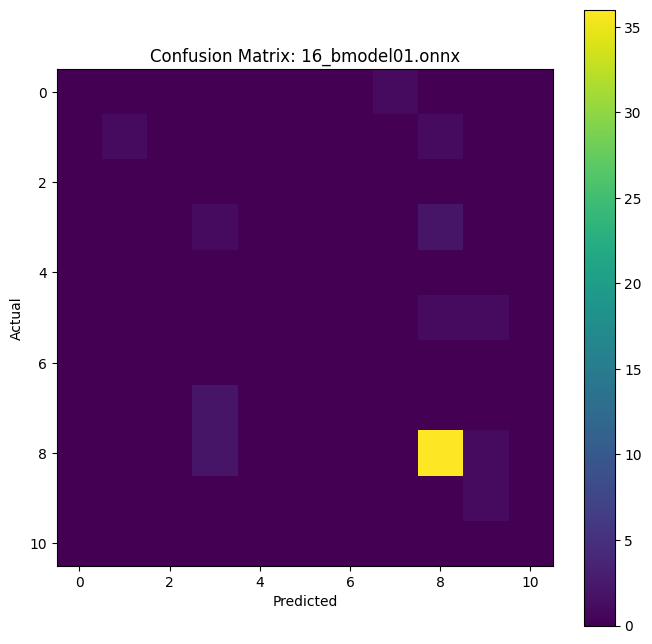

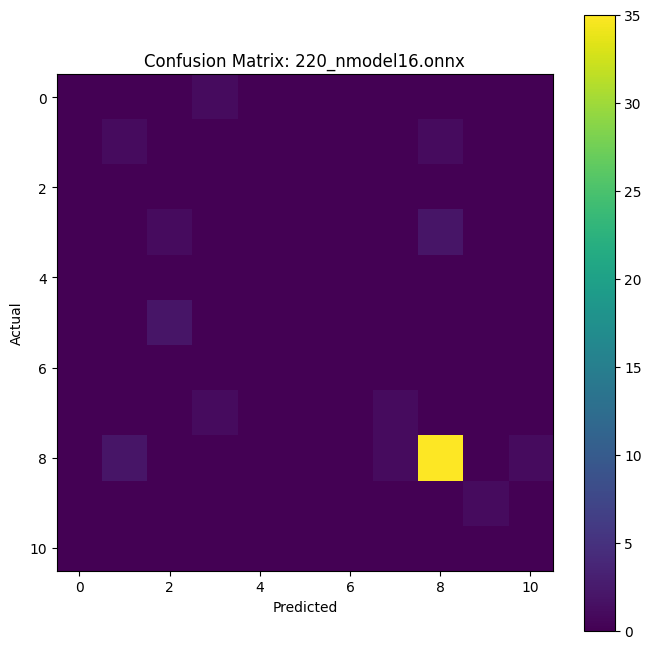

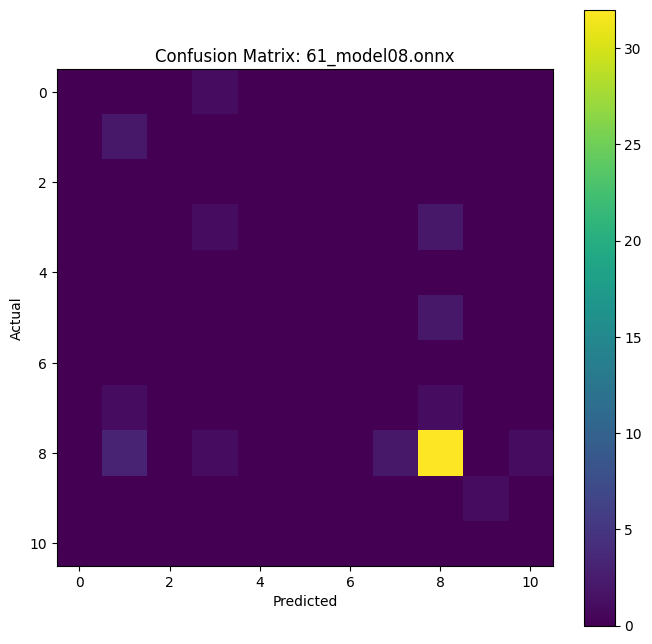

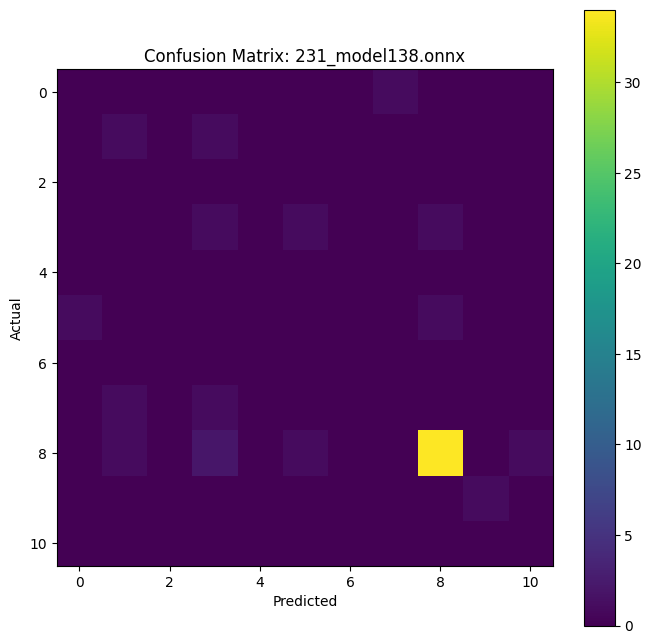

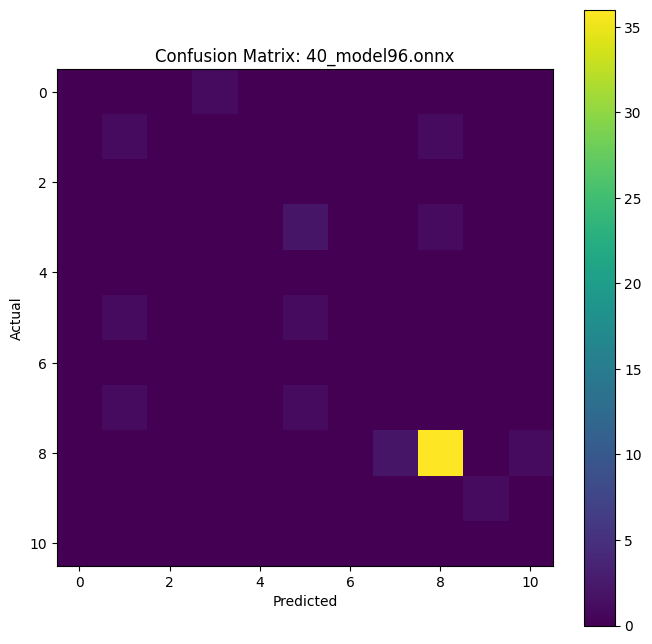

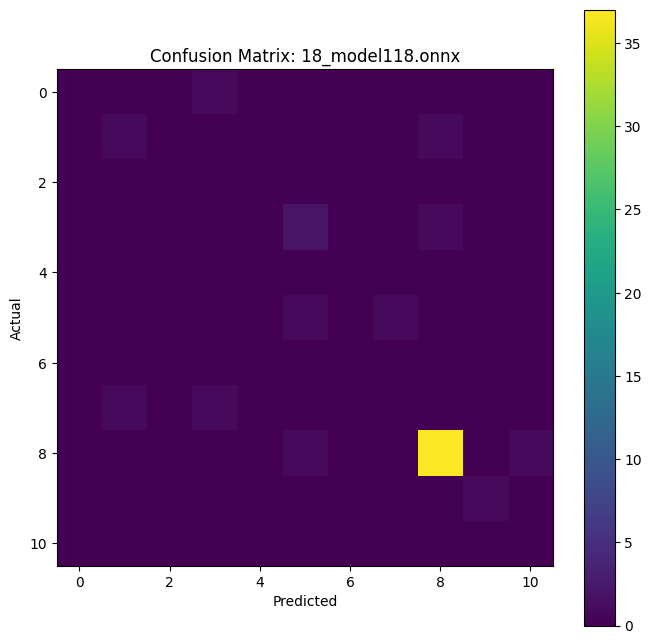

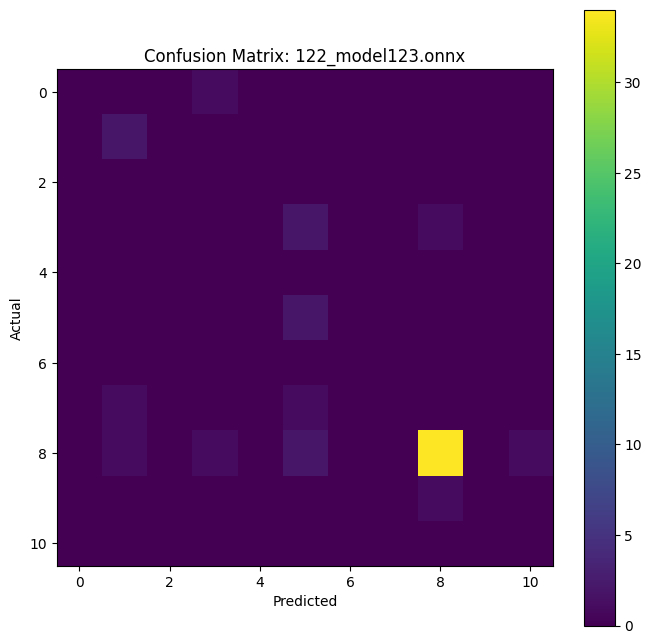

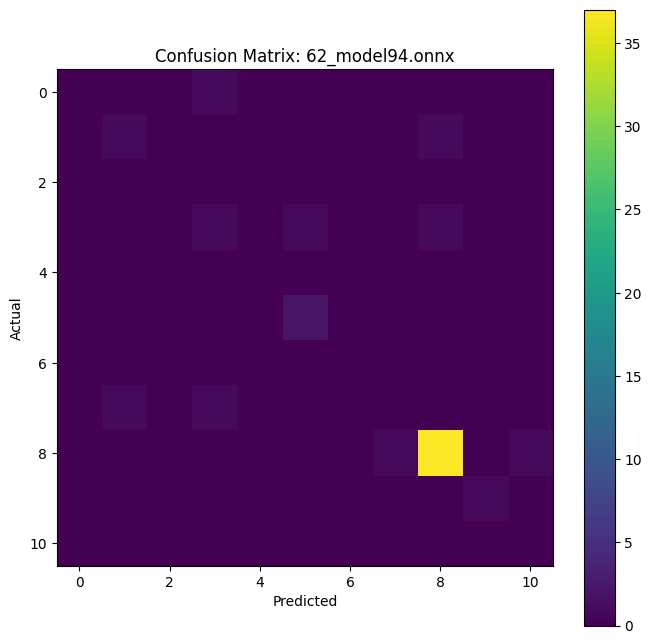

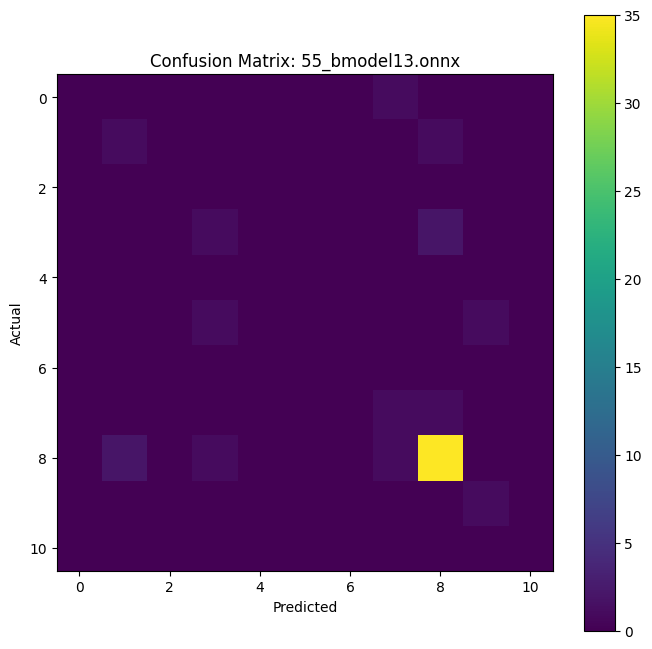

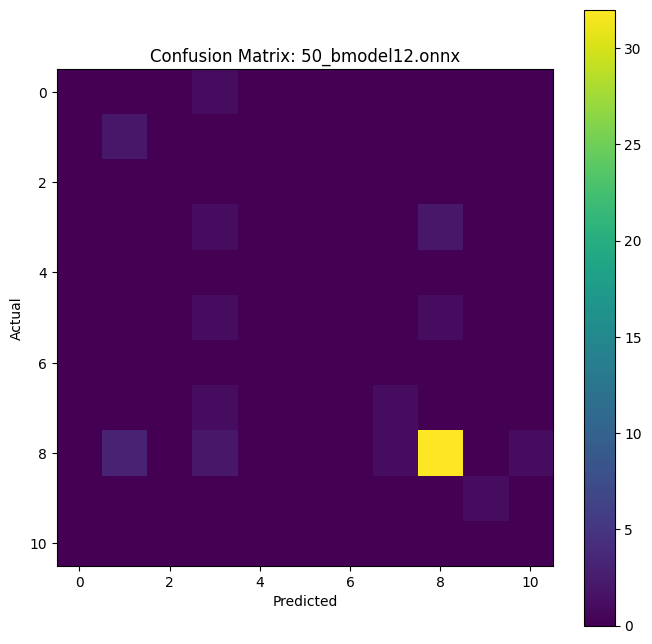

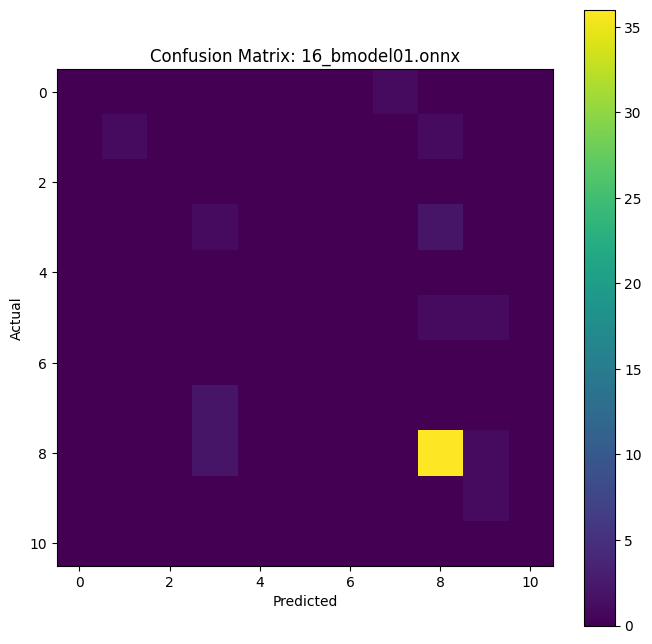

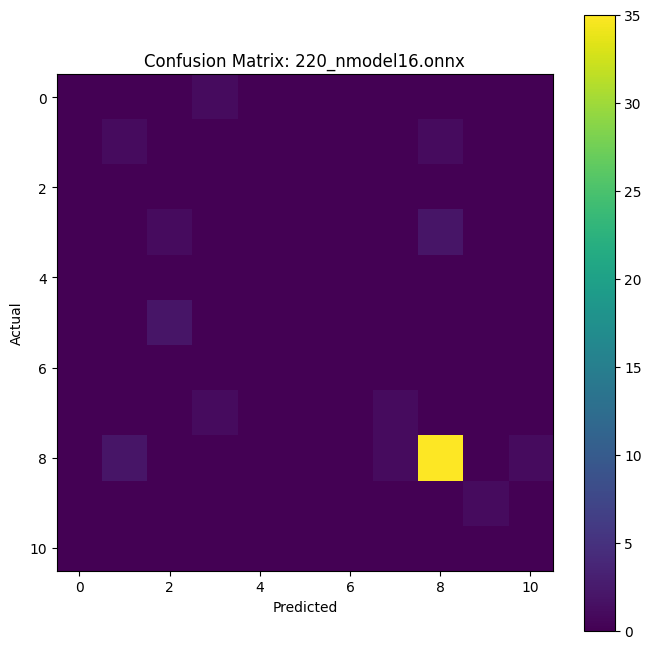

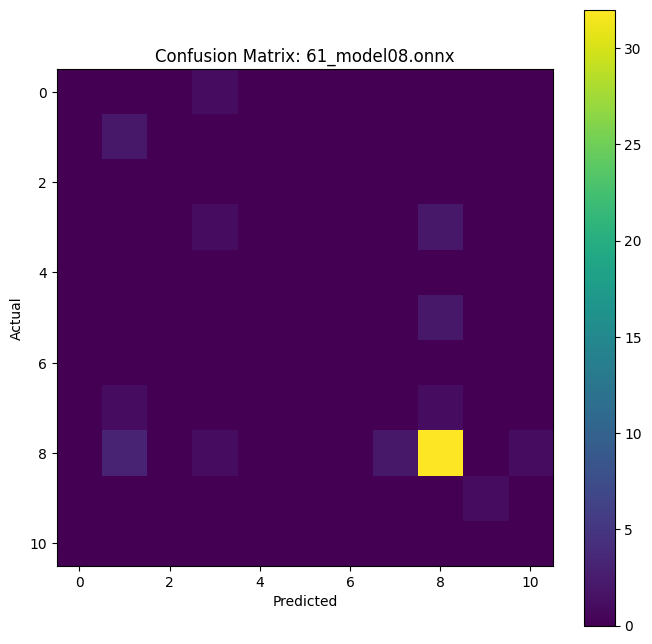

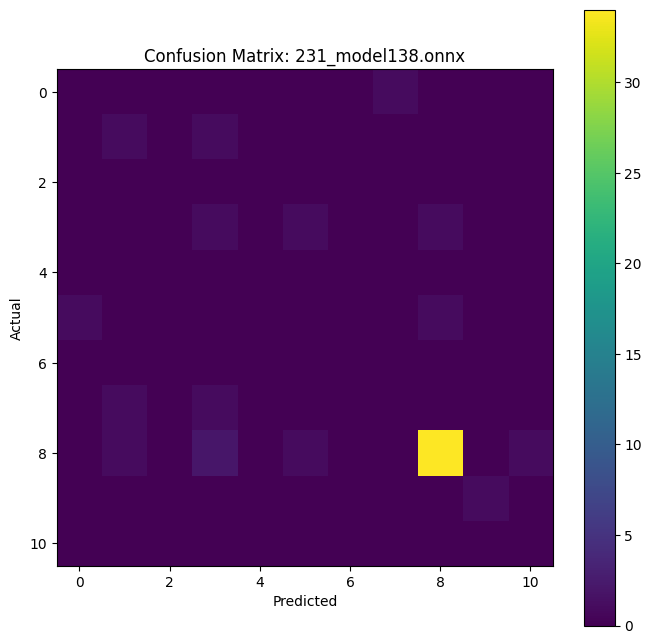

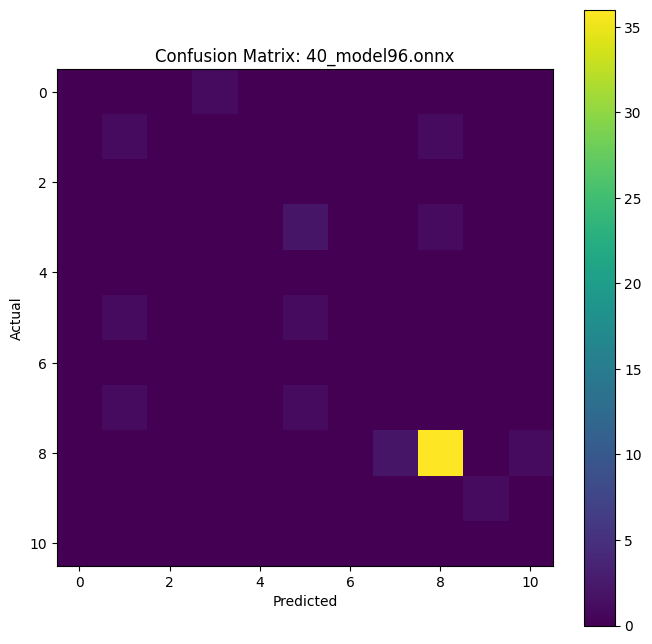

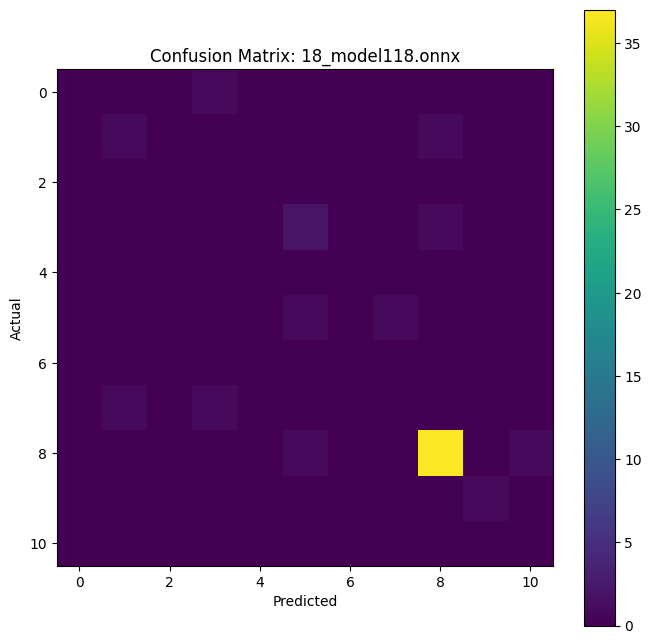

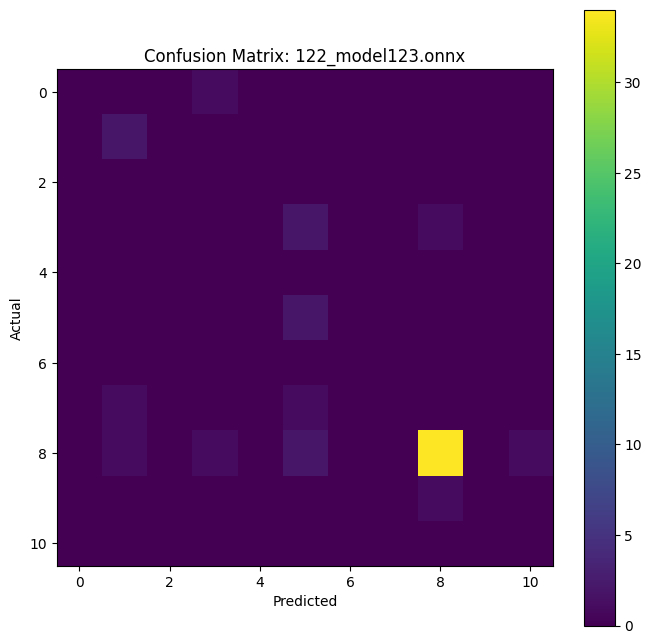

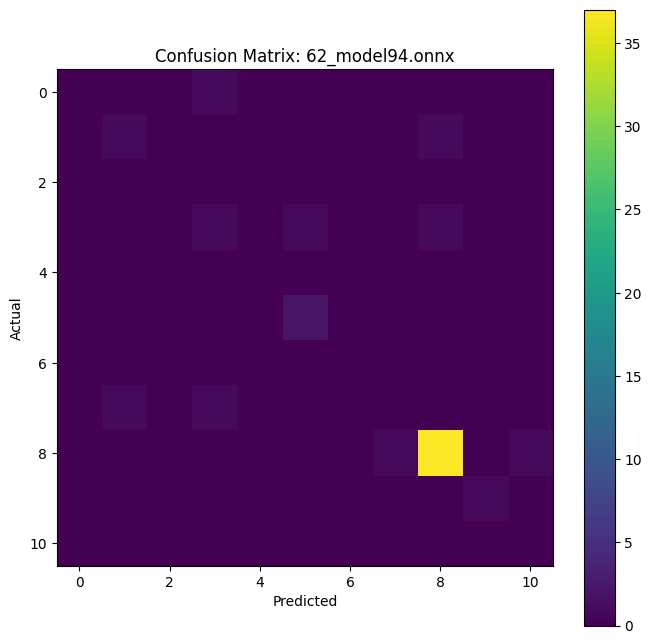

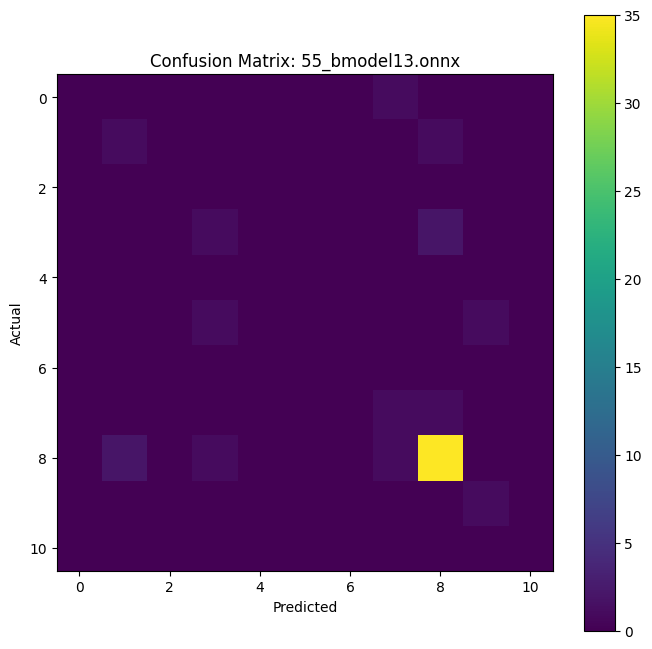

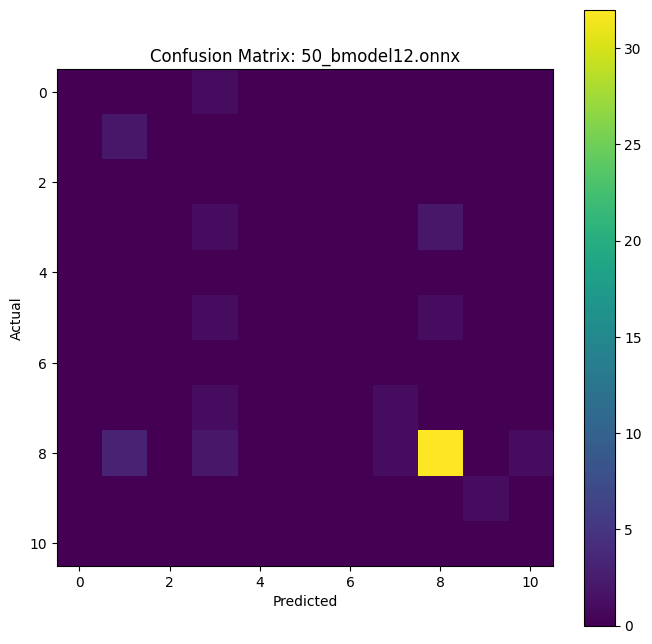

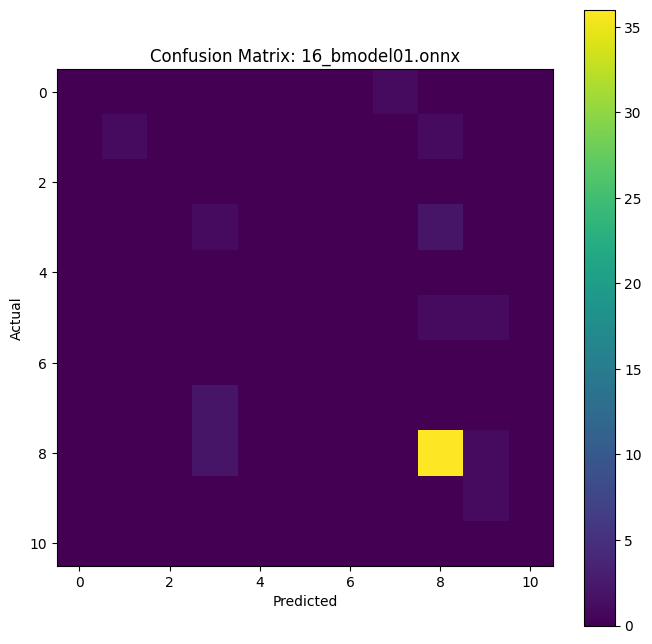

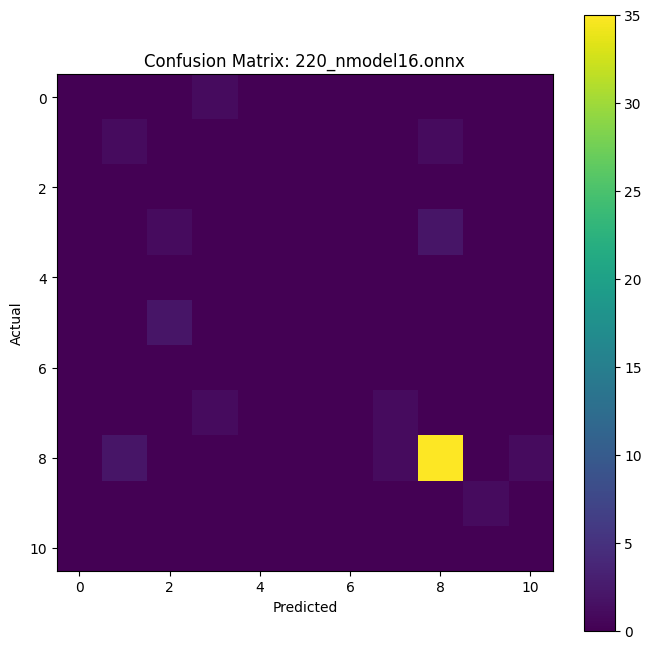

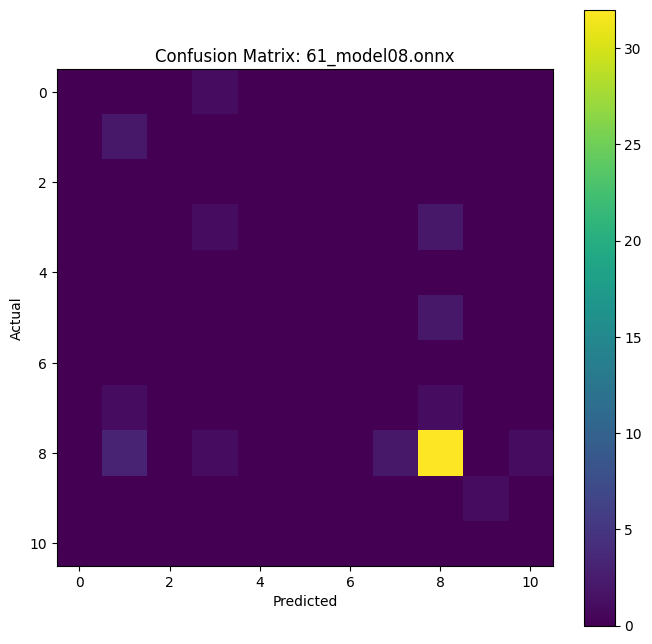

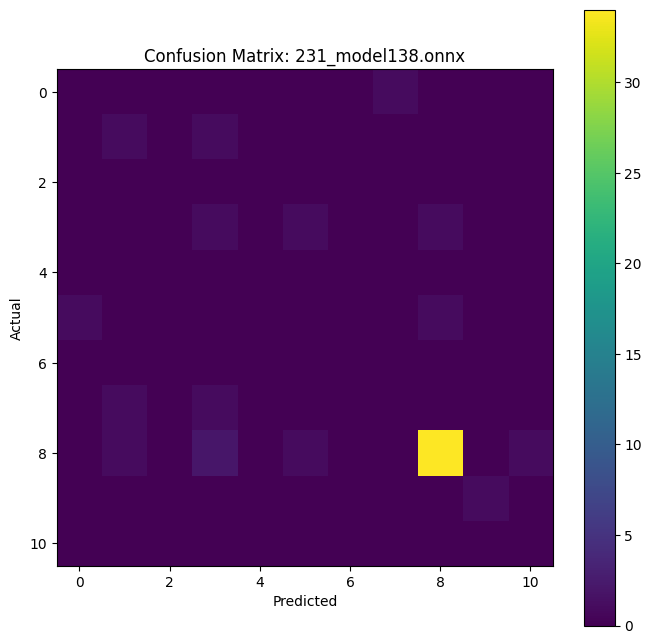

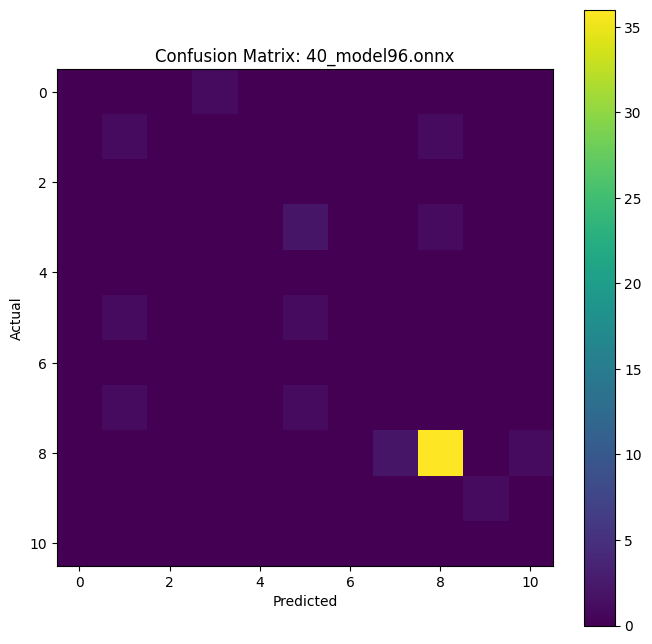

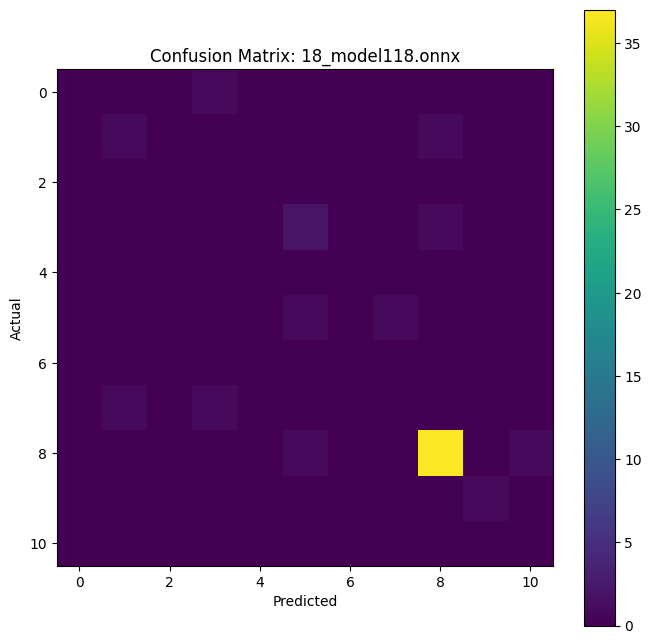

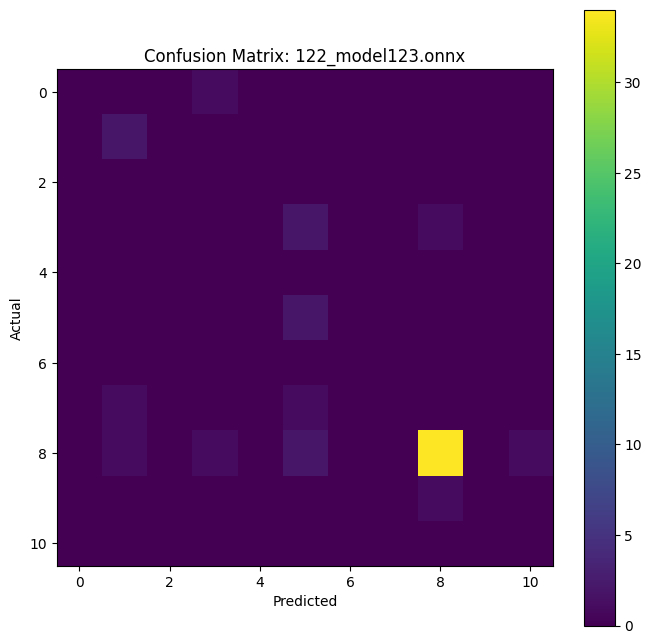

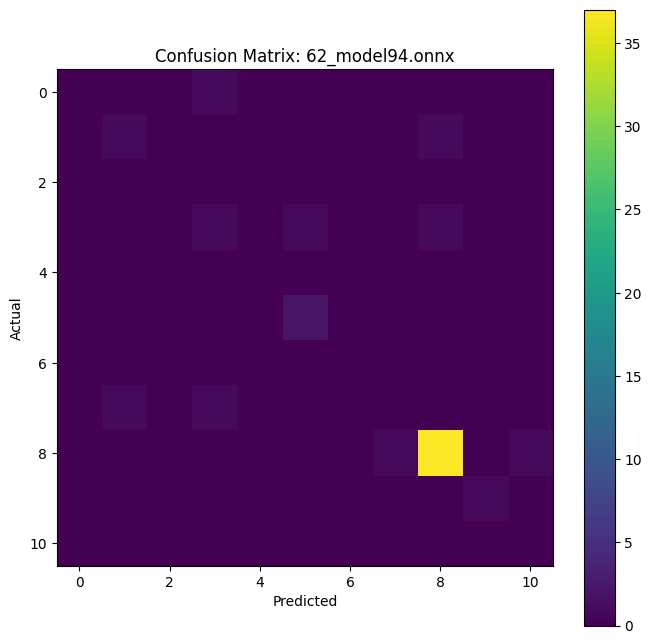

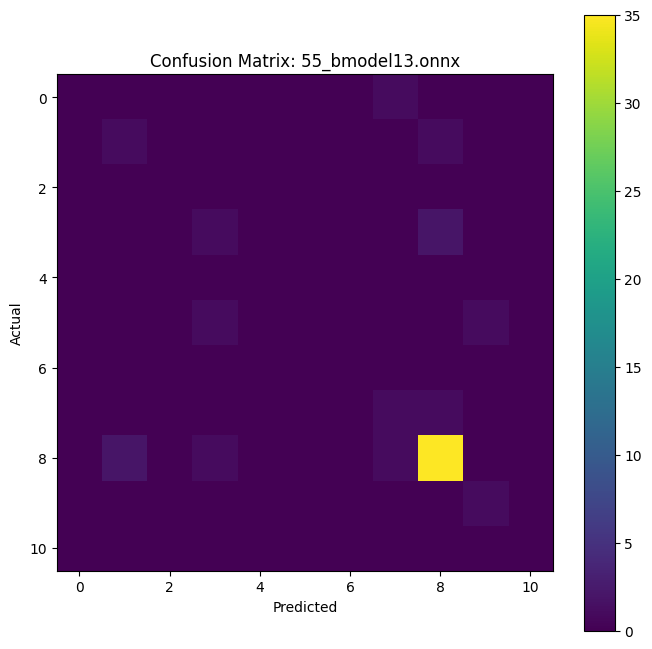

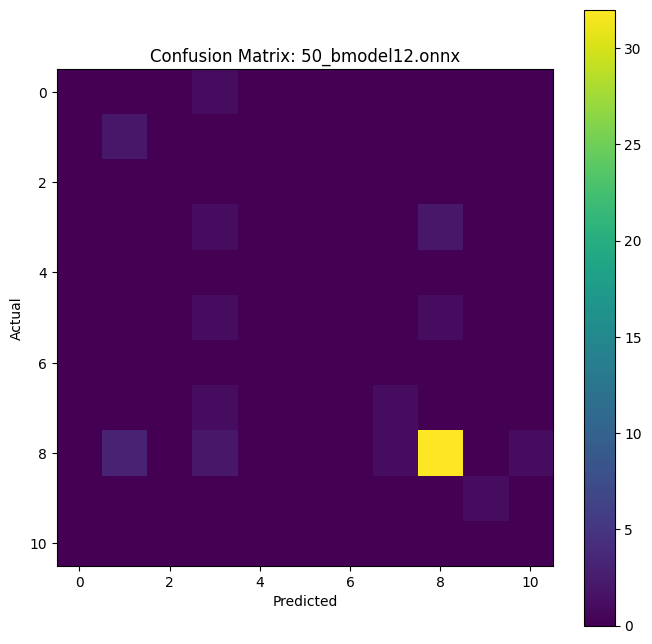

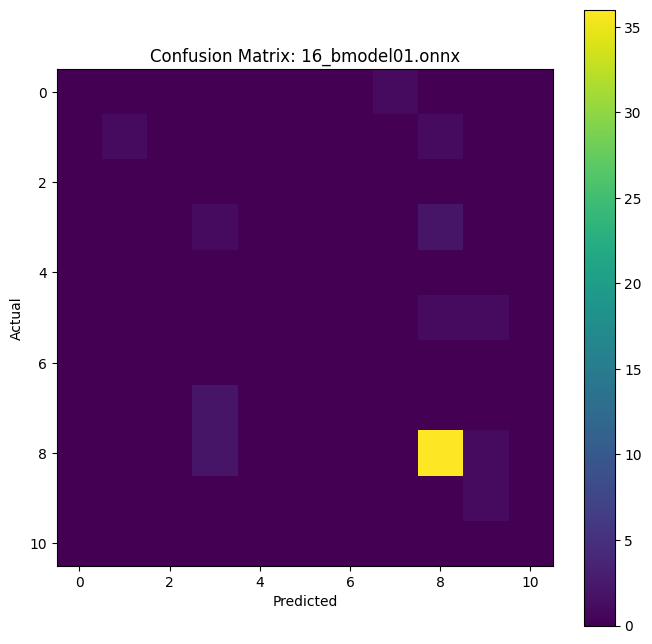

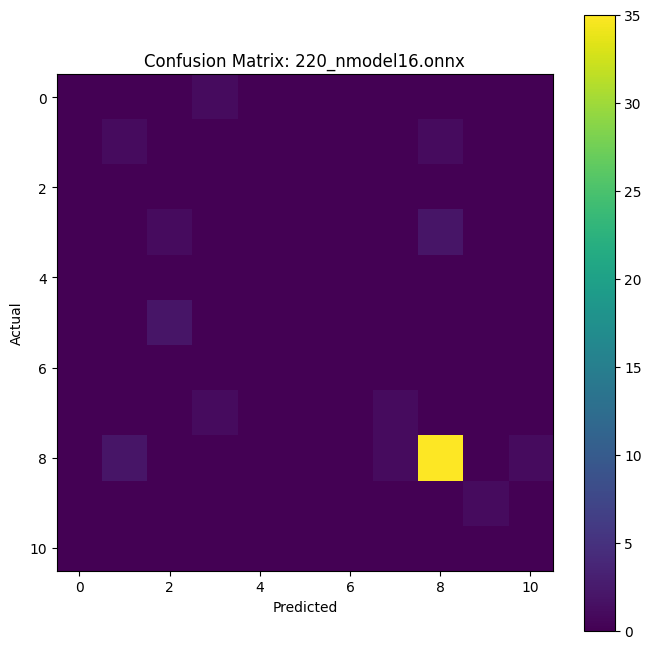

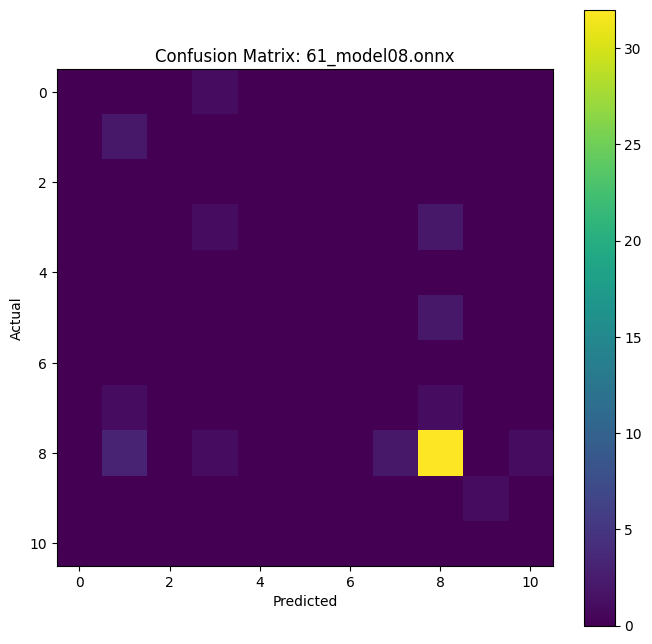

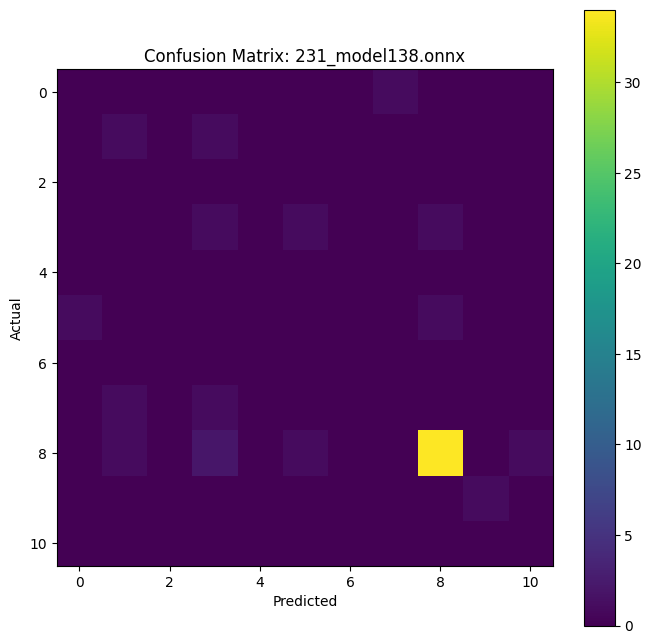

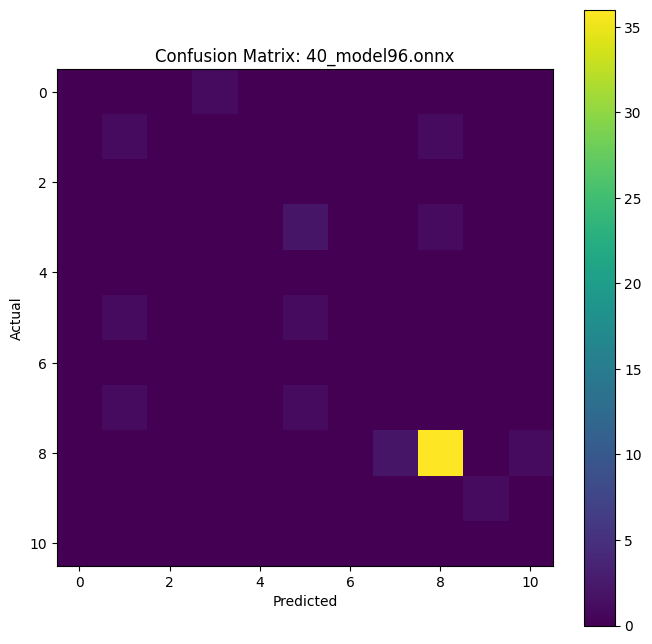

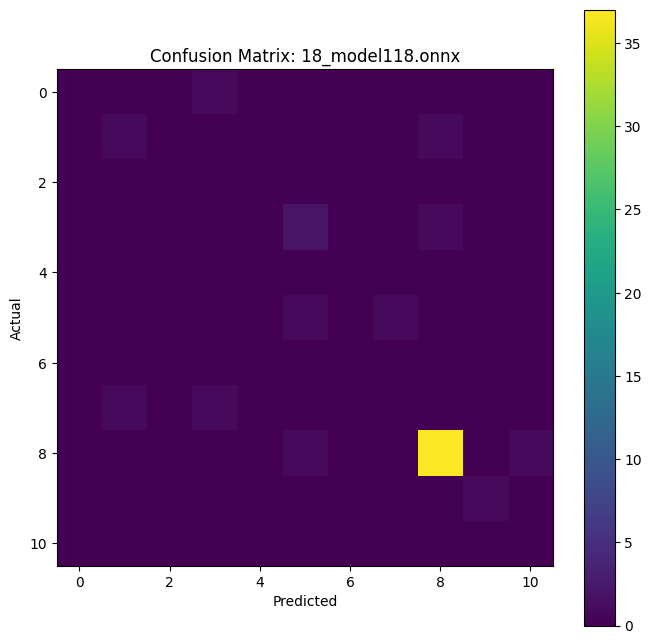

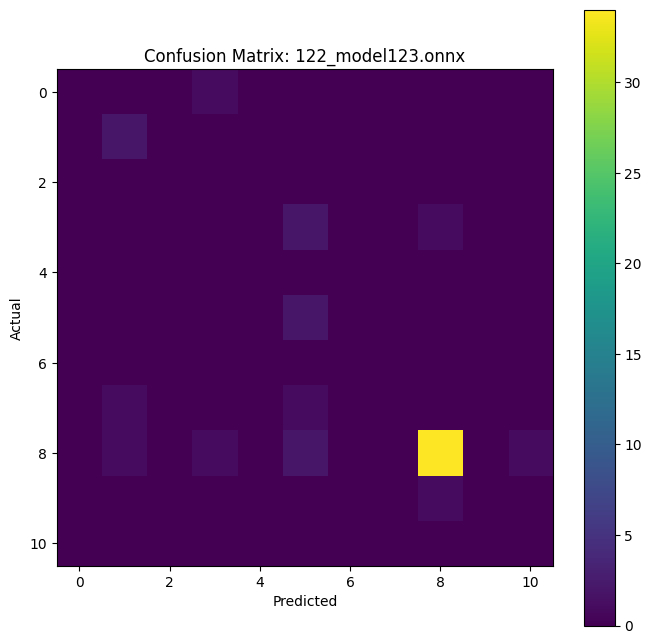

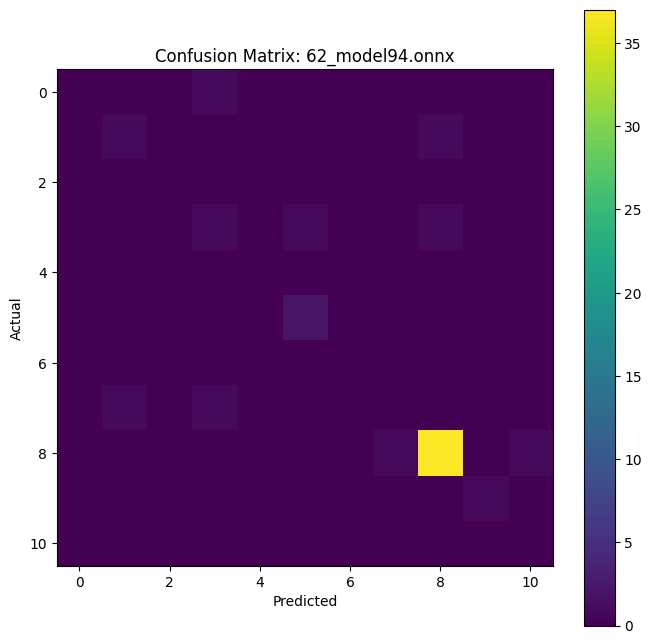

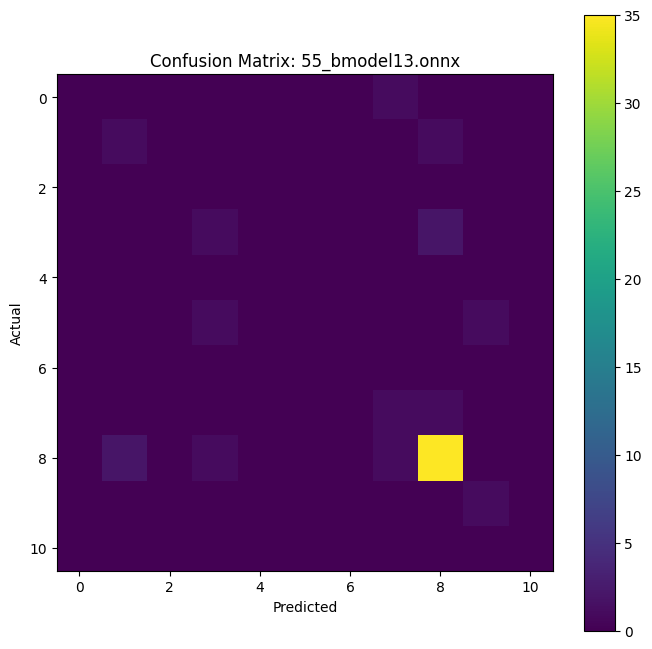

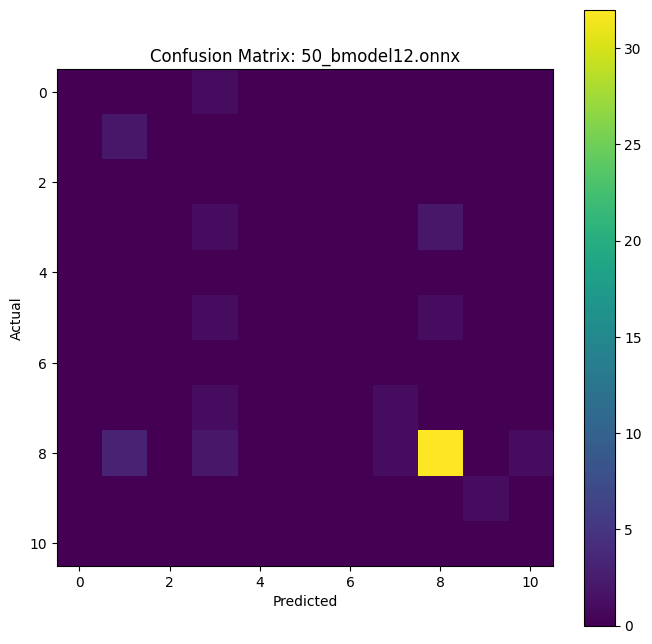

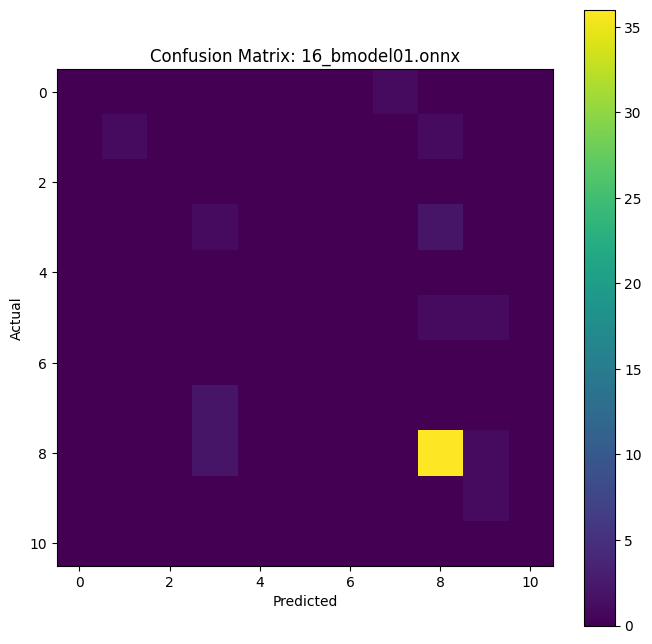

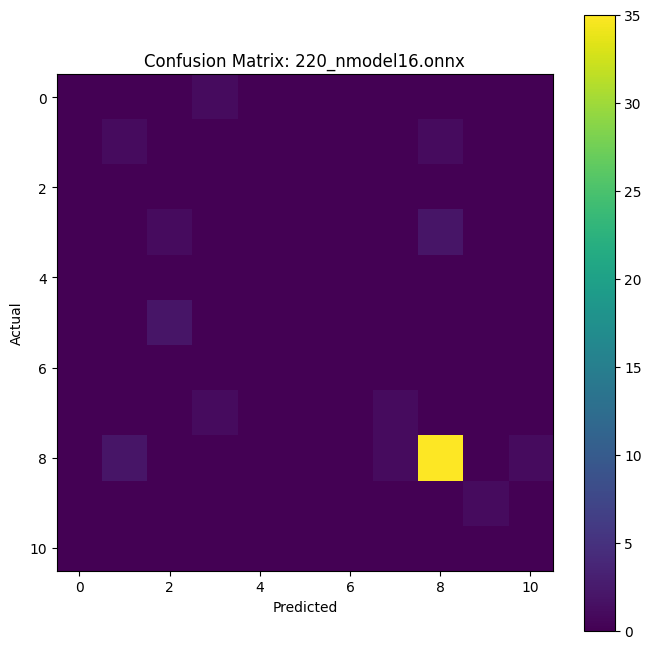

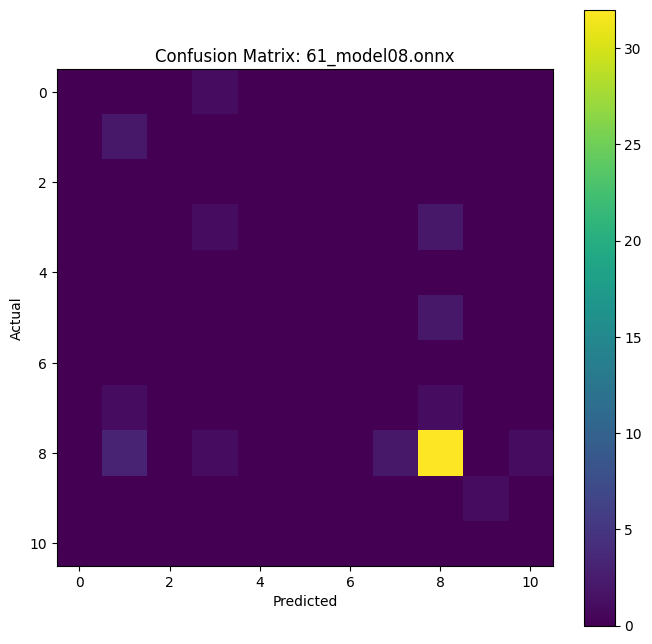

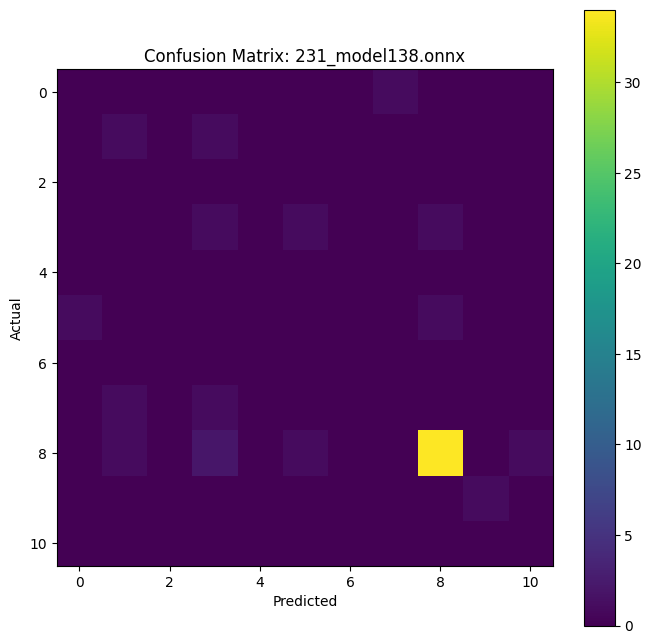

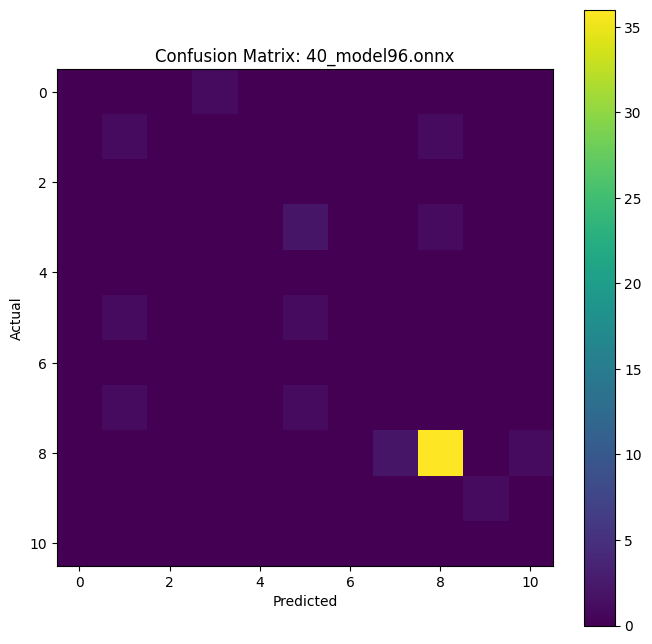

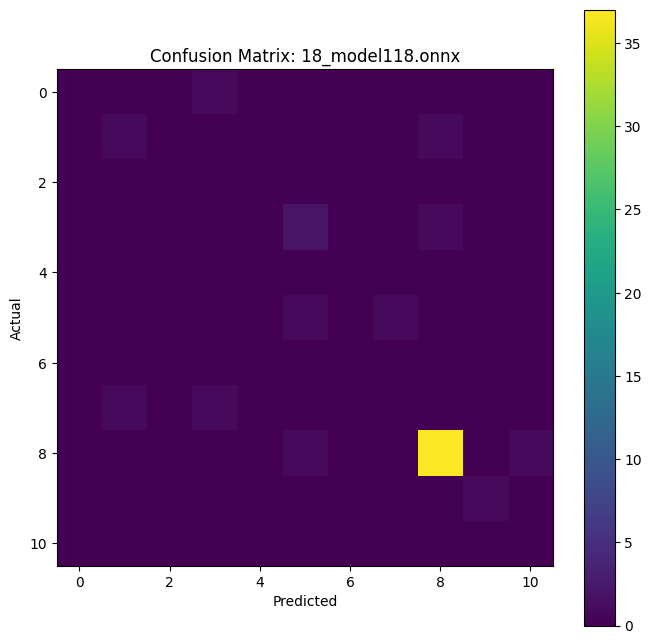

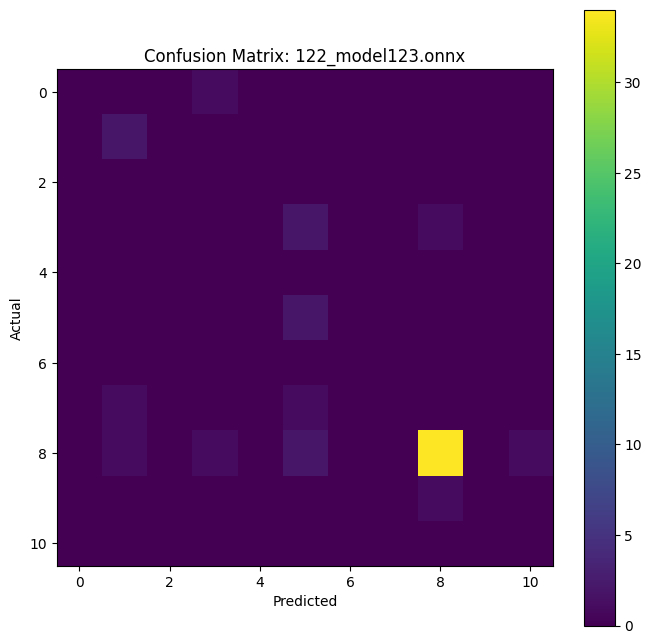

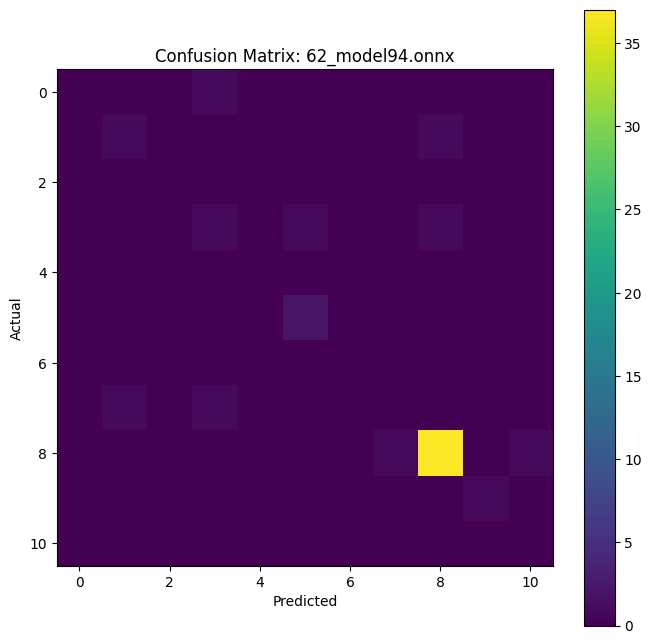

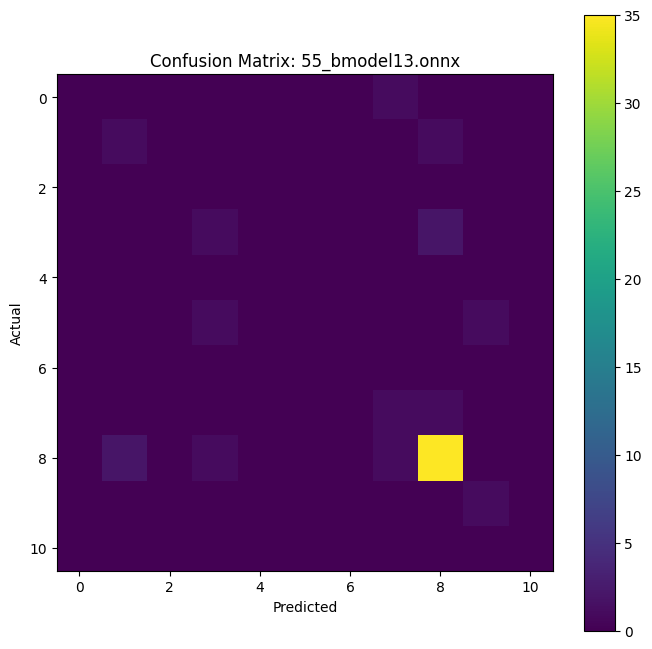

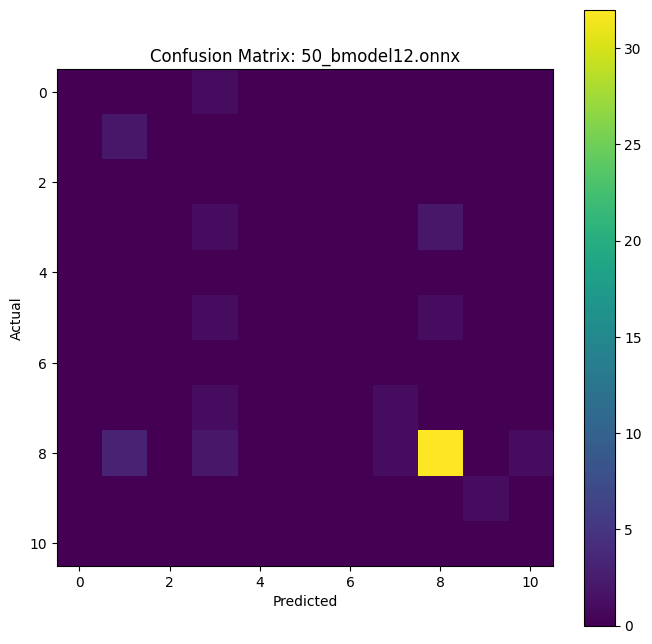

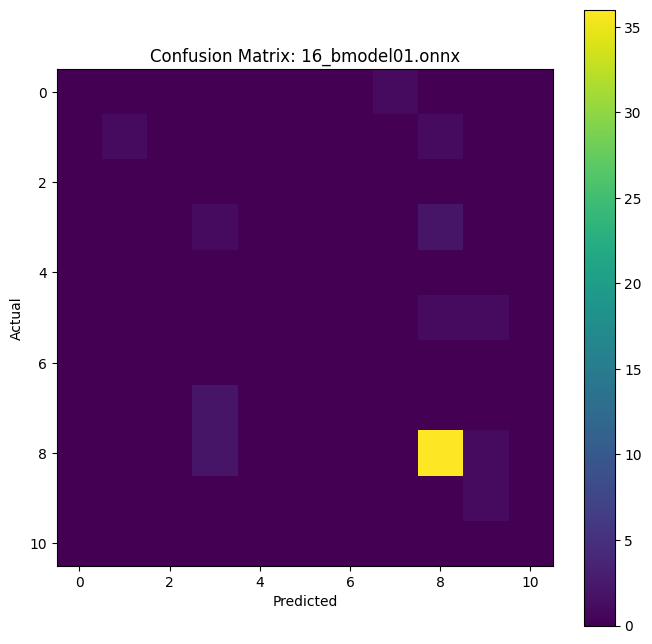

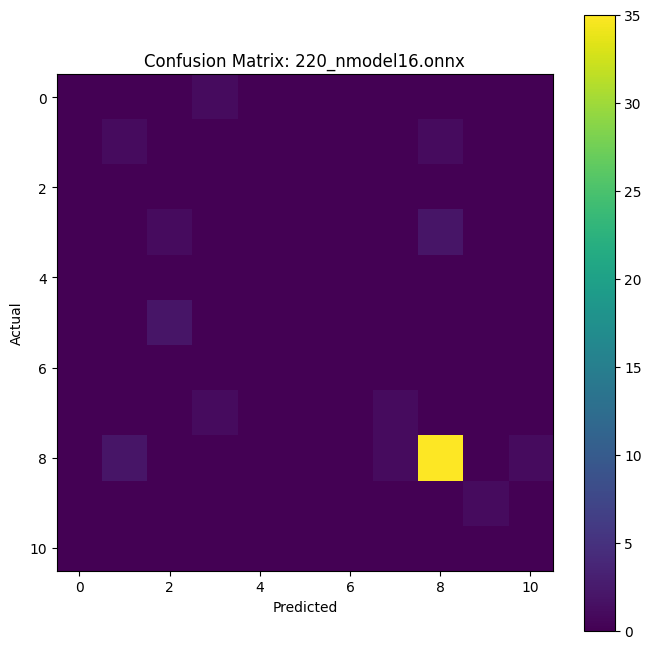

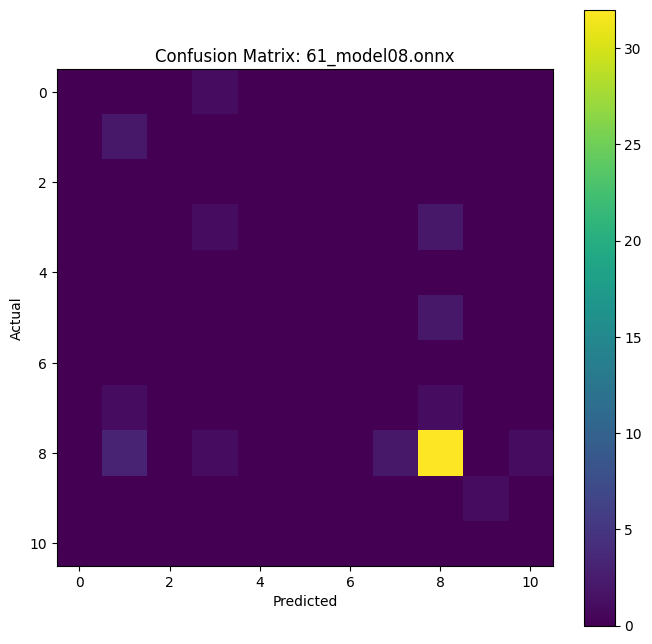

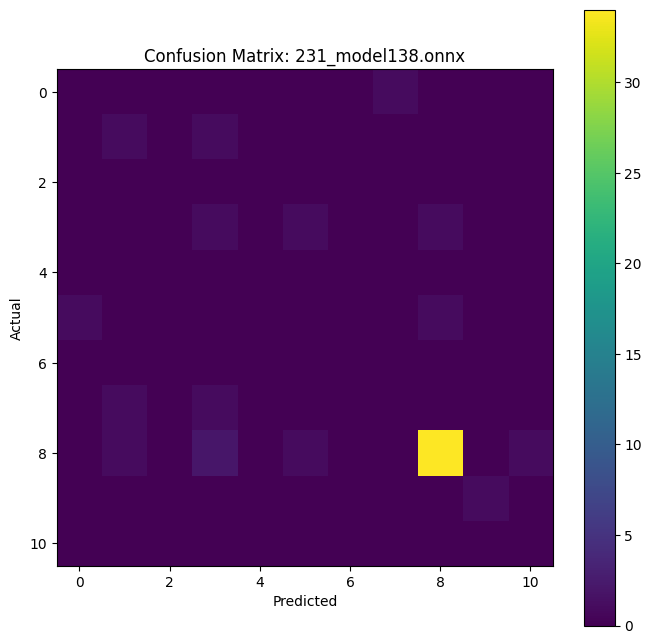

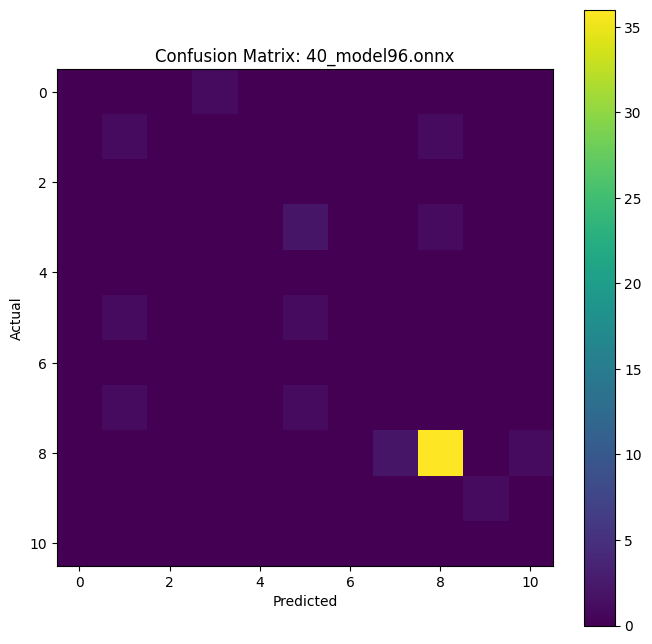

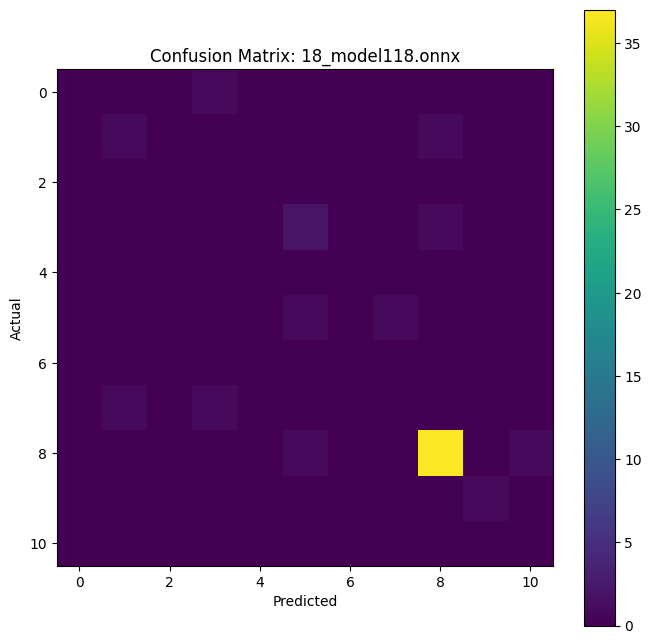

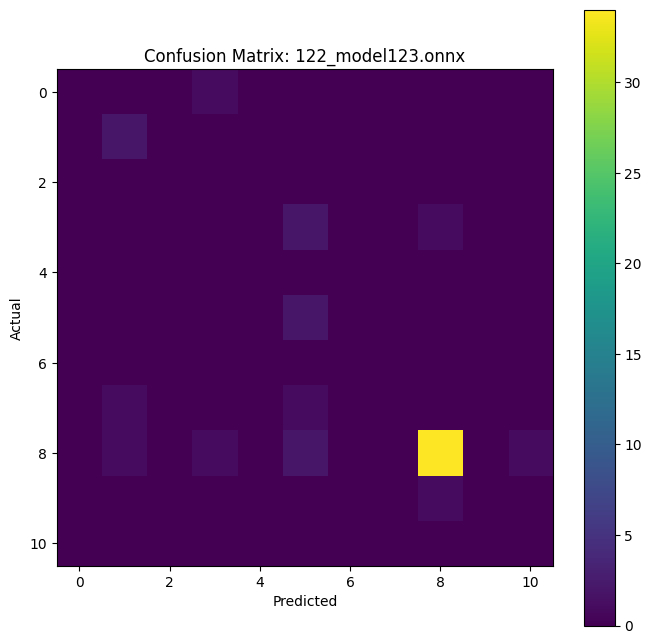

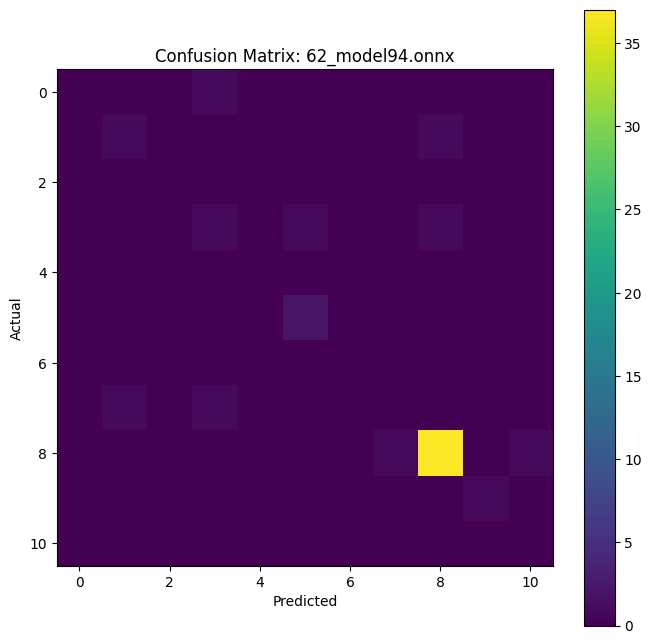

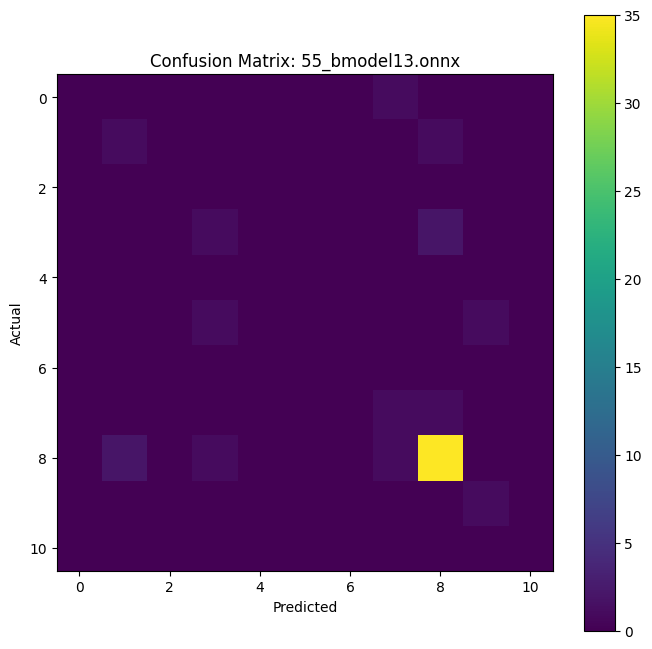

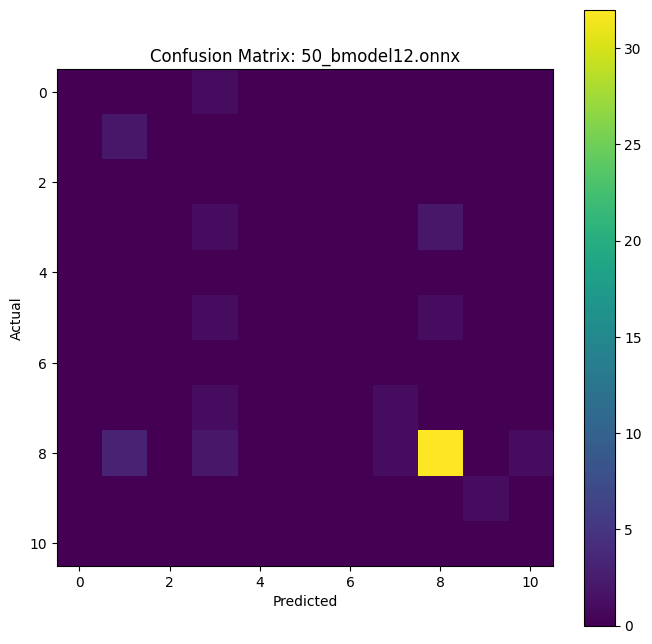

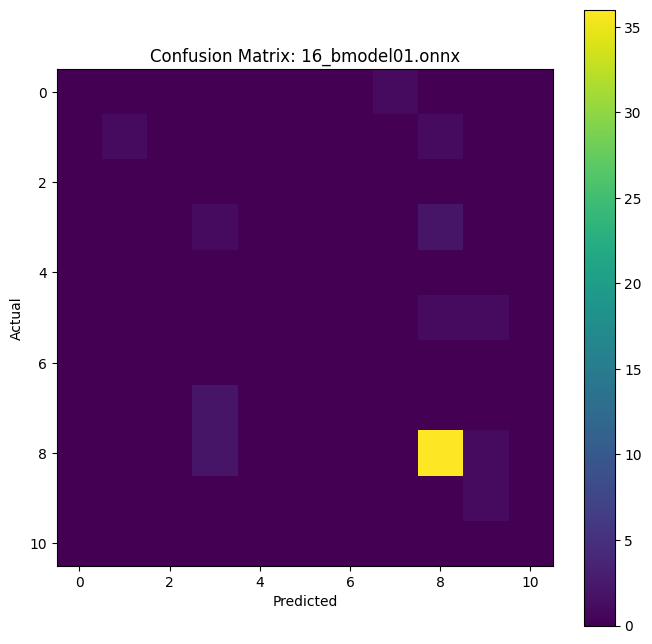

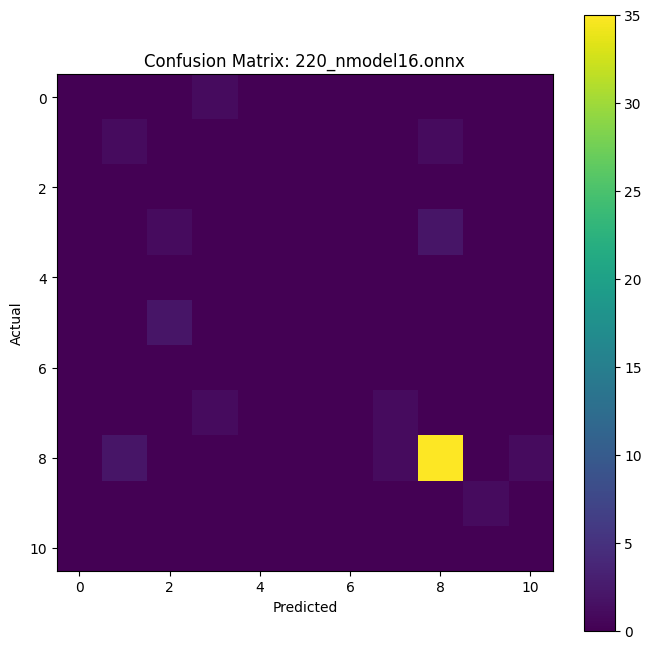

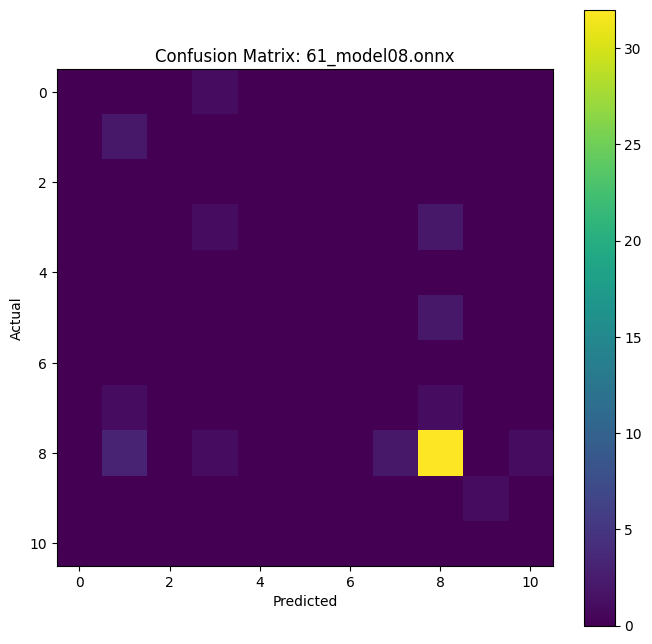

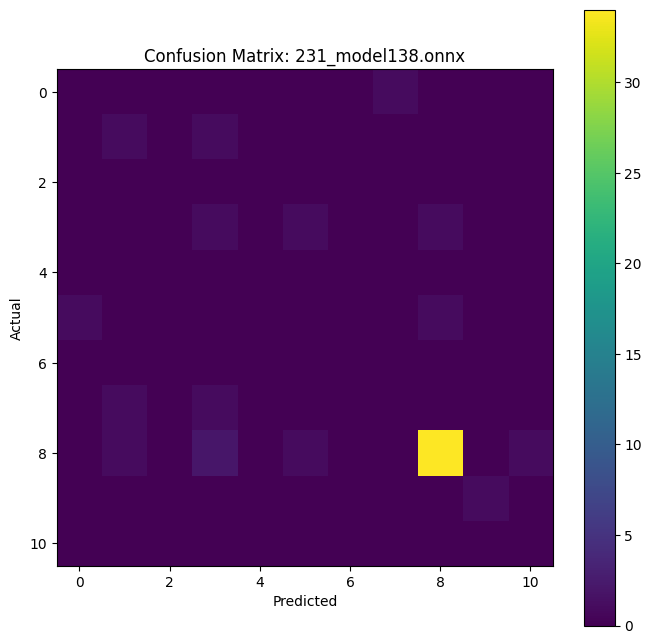

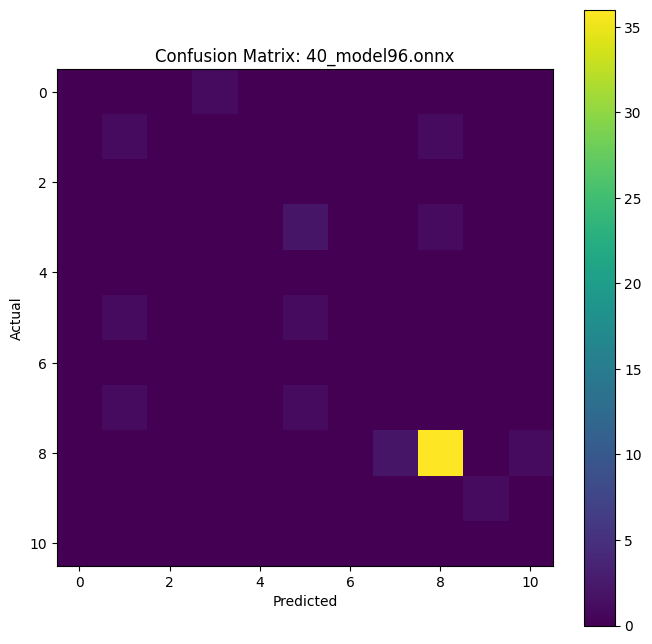

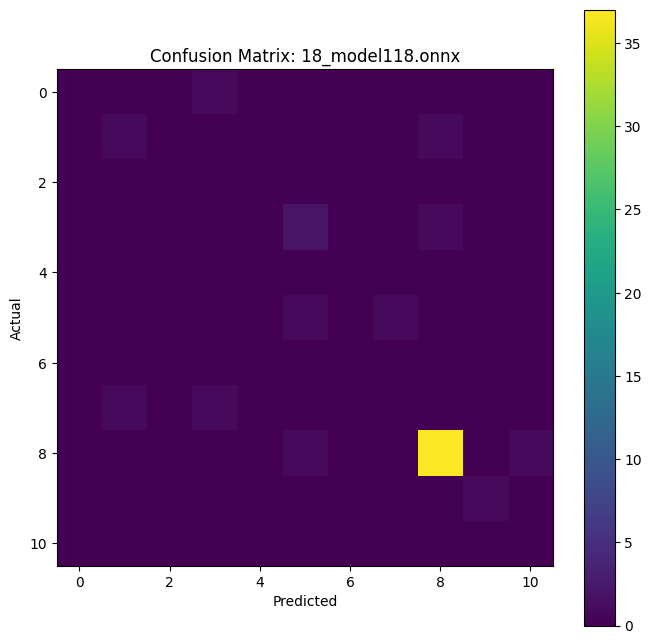

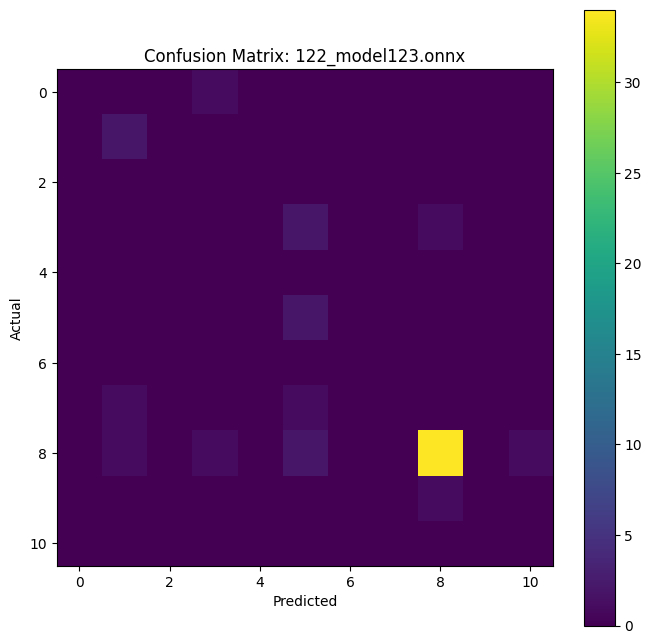

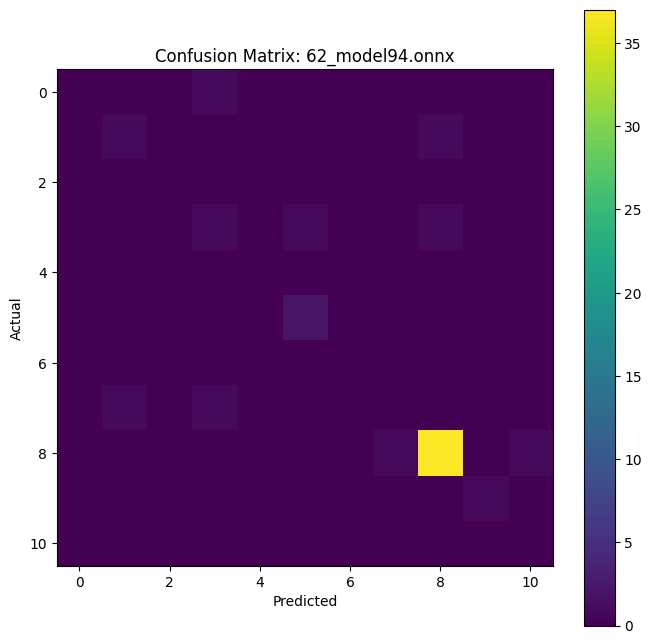

In [24]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

LOG_FILE = (
    "/home/mateo/cancer-ai/manager/logs/2025-11-28.log"  # <-- change this if needed
)


def load_log(path):
    with open(path, "r") as f:
        return json.load(f)


def extract_summary(data):
    rows = []
    for entry in data:
        model = os.path.basename(entry["model"])
        dataset = entry["dataset"]
        result = entry["result"]

        rows.append(
            {
                "model": model,
                "dataset": dataset,
                "score": result["score"],
                "accuracy": result["accuracy"],
                "precision": result["precision"],
                "recall": result["recall"],
                "fbeta": result["fbeta"],
                "weighted_f1": result["weighted_f1"],
                "efficiency_score": result["efficiency_score"],
                "run_time_s": result["run_time_s"],
            }
        )

    return pd.DataFrame(rows)


def plot_metric(df, metric):
    plt.figure(figsize=(10, 5))
    plt.bar(df["model"], df[metric])
    plt.xticks(rotation=75, ha="right")
    plt.ylabel(metric)
    plt.title(f"Model Comparison: {metric}")
    plt.tight_layout()
    plt.show()


def plot_class_f1(model_entry):
    classes = list(range(len(model_entry["result"]["f1_by_class"])))
    scores = model_entry["result"]["f1_by_class"]

    plt.figure(figsize=(10, 5))
    plt.bar(classes, scores)
    plt.title(f"Class F1 Scores: {os.path.basename(model_entry['model'])}")
    plt.xlabel("Class Index")
    plt.ylabel("F1 Score")
    plt.show()


def plot_confusion_matrix(model_entry):
    cm = np.array(model_entry["result"]["confusion_matrix"])

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix: {os.path.basename(model_entry['model'])}")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_f1_by_miner(log_entries):
    """
    Compare F1-by-class across all models in log_entries.
    """
    # List of models
    model_names = [os.path.basename(e["model"]) for e in log_entries]

    # Assume all entries have same number of classes
    num_classes = len(log_entries[0]["result"]["f1_by_class"])
    class_ids = list(range(num_classes))

    # Collect F1 scores for each model
    f1_matrix = [
        entry["result"]["f1_by_class"] 
        for entry in log_entries
    ]

    x = np.arange(num_classes)
    width = 0.8 / len(log_entries)  # dynamic bar width

    plt.figure(figsize=(14, 7))

    for i, (scores, model_name) in enumerate(zip(f1_matrix, model_names)):
        plt.bar(
            x + i * width,
            scores,
            width,
            label=model_name
        )

    plt.title("F1 Score Comparison Across Models (Per Class)", fontsize=14)
    plt.xlabel("Class Index", fontsize=12)
    plt.ylabel("F1 Score", fontsize=12)
    plt.xticks(x + width * (len(log_entries) - 1) / 2, class_ids)
    plt.ylim(0, 1.05)
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.legend(title="Models", fontsize=9)
    plt.tight_layout()
    plt.show()


def plot_risk_scores_by_dataset(log_entries, model_name=None):
    """
    Compare risk scores across datasets.
    If model_name is provided → filter by that model only.
    """

    # Filter by model (optional)
    if model_name:
        log_entries = [
            e for e in log_entries if os.path.basename(e["model"]) == model_name
        ]

    # Extract dataset names and risk dictionaries
    datasets = [entry["dataset"] for entry in log_entries]
    risk_dicts = [entry["result"]["risk_category_scores"] for entry in log_entries]

    # All categories (same for all entries)
    categories = list(risk_dicts[0].keys())

    # Build matrix: rows=risk categories, columns=datasets
    values = [[risk[c] for risk in risk_dicts] for c in categories]

    # Plot
    x = range(len(datasets))
    width = 0.15

    plt.figure(figsize=(10, 6))

    for i, category in enumerate(categories):
        plt.bar([xi + i * width for xi in x], values[i], width, label=category)

    plt.xticks([xi + width for xi in x], datasets, rotation=45, ha="right")
    title = f"Risk Score Comparison Across Datasets"
    if model_name:
        title += f" — {model_name}"

    plt.title(title)
    plt.ylabel("Risk Score")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_risk_scores(model_entry):
    risks = model_entry["result"]["risk_category_scores"]
    labels = list(risks.keys())
    values = list(risks.values())

    plt.figure(figsize=(6, 5))
    plt.bar(labels, values)
    plt.title(f"Risk Category Scores: {os.path.basename(model_entry['model'])}")
    plt.ylabel("Score")
    plt.show()


def main():
    print("Loading log...")
    data = load_log(LOG_FILE)

    print("Building summary table...")
    df = extract_summary(data)
    print(df)

    # Plot comparisons across all models
    # plot_metric(df, "accuracy")
    # plot_metric(df, "score")
    # plot_metric(df, "precision")
    # plot_metric(df, "recall")
    # plot_metric(df, "weighted_f1")
    # plot_metric(df, "efficiency_score")
    # plot_metric(df, "run_time_s")

    # plot_risk_scores_by_dataset(data)
    plot_f1_by_miner(data)


    # Detailed plots for each model
    for entry in data:
        # plot_class_f1(entry)
        plot_confusion_matrix(entry)
        # plot_risk_scores(entry)


if __name__ == "__main__":
    main()

# F1 Score Analyze by class

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Optional, Sequence, Dict, Any

def build_f1_dataframe(log_entries: Sequence[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert log entries into a DataFrame indexed by model name with columns per class.
    Expects each entry to have: entry['model'] and entry['result']['f1_by_class'].
    """
    rows = {}
    for entry in log_entries:
        model_name = os.path.basename(entry["model"])
        f1_list = entry["result"]["f1_by_class"]
        rows[model_name] = f1_list
    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index.name = "model"
    df.columns = [f"class_{i}" for i in range(df.shape[1])]
    return df.sort_index()

def plot_f1_by_miner(
    log_entries: Sequence[Dict[str, Any]],
    models_order: Optional[Sequence[str]] = None,
    figsize_per_plot: tuple = (4, 3),
    annotate: bool = True,
    sort_models_per_class: bool = False,
    figsize_max: Optional[tuple] = None,
    cmap: Optional[str] = None
):
    """
    Plot F1-by-class split into individual subplots (one subplot per class).
    - log_entries: list of dicts as in your log
    - models_order: optional sequence of model basenames to fix order; defaults to dataframe index order
    - figsize_per_plot: (width, height) for each subplot
    - annotate: whether to show numeric F1 above bars
    - sort_models_per_class: if True, sort models by F1 value inside each class subplot (helps highlight top models per class)
    - figsize_max: optional (w,h) to cap final figure size to avoid extremely large windows
    - cmap: optional matplotlib colormap name for bars
    Returns: pandas.DataFrame of F1 scores (models x classes)
    """

    df = build_f1_dataframe(log_entries)  # models × classes
    n_models, n_classes = df.shape

    if n_classes == 0:
        raise ValueError("No classes found in log entries.")

    # Determine model order
    if models_order:
        # use provided order, but keep only those present
        model_order = [m for m in models_order if m in df.index]
        # append any missing models at the end
        model_order += [m for m in df.index if m not in model_order]
    else:
        model_order = list(df.index)

    # layout: choose grid rows/cols
    cols = min(4, n_classes)              # prefer up to 4 columns
    rows = math.ceil(n_classes / cols)

    fig_w = max(1, figsize_per_plot[0] * cols)
    fig_h = max(1, figsize_per_plot[1] * rows)
    if figsize_max:
        fig_w = min(fig_w, figsize_max[0])
        fig_h = min(fig_h, figsize_max[1])

    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), squeeze=False)
    axes_flat = axes.flatten()

    # colormap
    if cmap:
        cmap_obj = plt.get_cmap(cmap)
        colors = [cmap_obj(i / max(1, n_models - 1)) for i in range(n_models)]
    else:
        colors = None  # matplotlib default cycle

    for class_idx in range(n_classes):
        ax = axes_flat[class_idx]
        colname = df.columns[class_idx]

        # prepare data for this class
        class_series = df[colname].reindex(model_order)  # keep requested model order

        if sort_models_per_class:
            class_series = class_series.sort_values(ascending=False)

        x = np.arange(len(class_series))
        bar_colors = colors if colors is not None else None

        bars = ax.bar(x, class_series.values, color=bar_colors)

        # labels and ticks
        ax.set_title(colname, fontsize=10)
        ax.set_xticks(x)
        ax.set_xticklabels(class_series.index, rotation=45, ha="right", fontsize=8)
        ax.set_ylim(0, 1.05)
        ax.grid(axis="y", linestyle="--", alpha=0.25)

        # annotate
        if annotate:
            for b, val in zip(bars, class_series.values):
                ax.text(b.get_x() + b.get_width() / 2, val + 0.01, f"{val:.3f}",
                        ha="center", va="bottom", fontsize=7)

    # disable extra subplots if any
    for i in range(n_classes, rows * cols):
        axes_flat[i].axis("off")

    plt.suptitle("Per-Class F1 Comparison Across Models", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return df


In [ ]:
print("Loading log...")
data = load_log(LOG_FILE)

df = plot_f1_by_miner(data, cmap="tab20", figsize_per_plot=(5, 4), figsize_max=(15, 12))

# Class vs F1 vs Model

In [9]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
LOG_FILE = (
    "/home/mateo/cancer-ai/manager/logs/2025-11-28.log"  # <-- change this if needed
)


def load_log(path):
    with open(path, "r") as f:
        return json.load(f)


data = load_log(LOG_FILE)

In [20]:
# ---------------------------------------------------
# Convert each log into a row in comparison table
# ---------------------------------------------------
rows = []
for log in data:
    r = log["result"]
    row = {
        "model": log["model"].split("/")[-1],
        "dataset": log["dataset"],
        "score": r.get("score"),
        "accuracy": r.get("accuracy"),
        "precision": r.get("precision"),
        "recall": r.get("recall"),
        "weighted_f1": r.get("weighted_f1"),
        "fbeta": r.get("fbeta"),
        "efficiency_score": r.get("efficiency_score"),
        "macro_f1": np.mean(r["f1_by_class"]),
    }
    rows.append(row)

df = pd.DataFrame(rows)

# ---------------------------------------------------
# Print comparison table
# ---------------------------------------------------
print("\n=== MODEL PERFORMANCE COMPARISON BY DATASET ===")
print(df.to_string(index=False))


=== MODEL PERFORMANCE COMPARISON BY DATASET ===
            model                         dataset    score  accuracy  precision  recall  weighted_f1    fbeta  efficiency_score  macro_f1
 55_bmodel13.onnx manager/dataset/csv_class/AKIEC 0.566994      0.78   0.756667    0.78     0.257764 0.765333               1.0  0.245221
 50_bmodel12.onnx manager/dataset/csv_class/AKIEC 0.576845      0.74   0.779143    0.74     0.319656 0.750785               1.0  0.287138
 16_bmodel01.onnx manager/dataset/csv_class/AKIEC 0.546214      0.78   0.760667    0.78     0.211586 0.762553               1.0  0.211642
220_nmodel16.onnx manager/dataset/csv_class/AKIEC 0.565921      0.76   0.771754    0.76     0.275379 0.765091               1.0  0.255372
  61_model08.onnx manager/dataset/csv_class/AKIEC 0.540831      0.72   0.727928    0.72     0.259625 0.716842               1.0  0.243222
231_model138.onnx manager/dataset/csv_class/AKIEC 0.541250      0.74   0.782000    0.74     0.240556 0.758200              

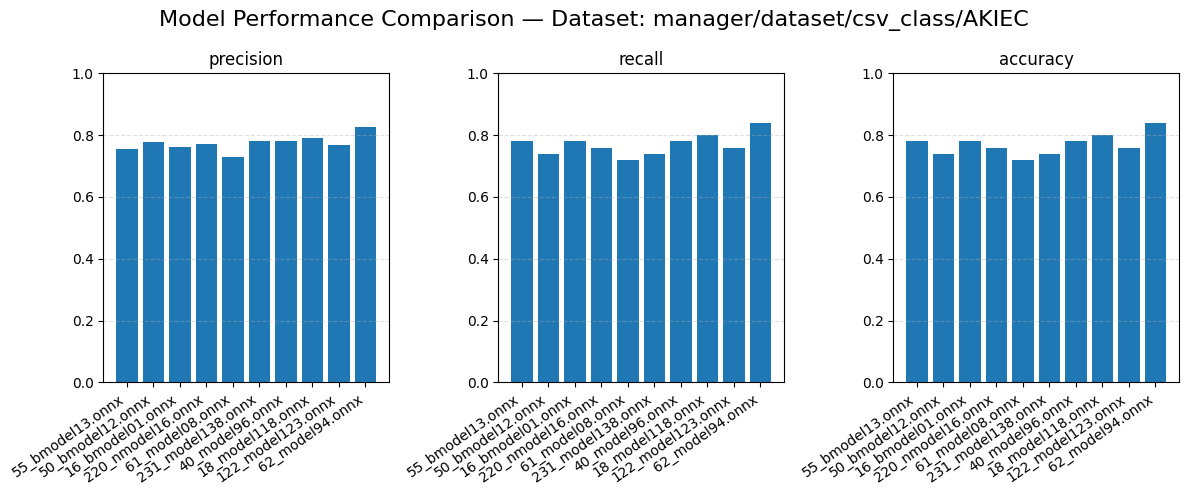

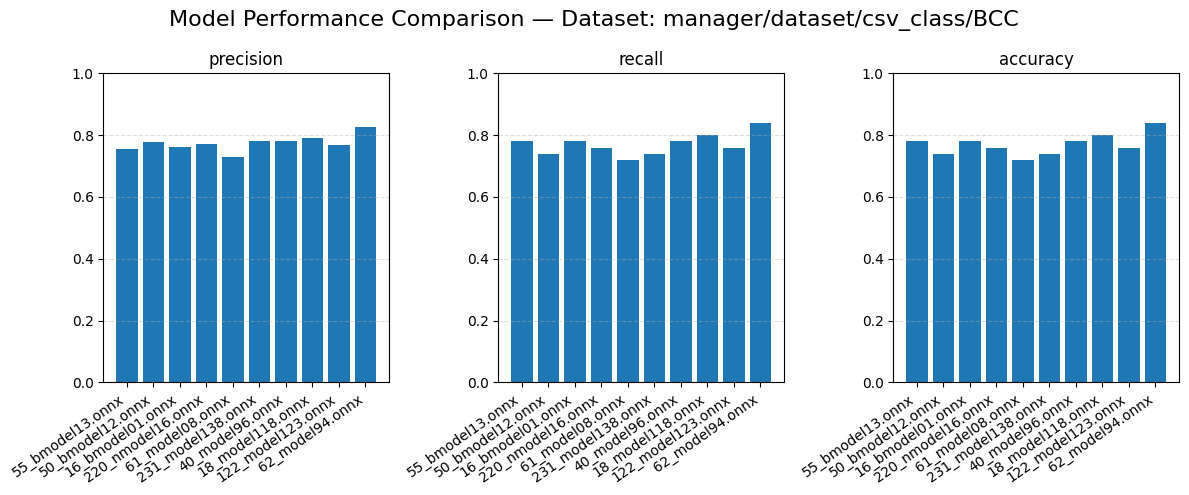

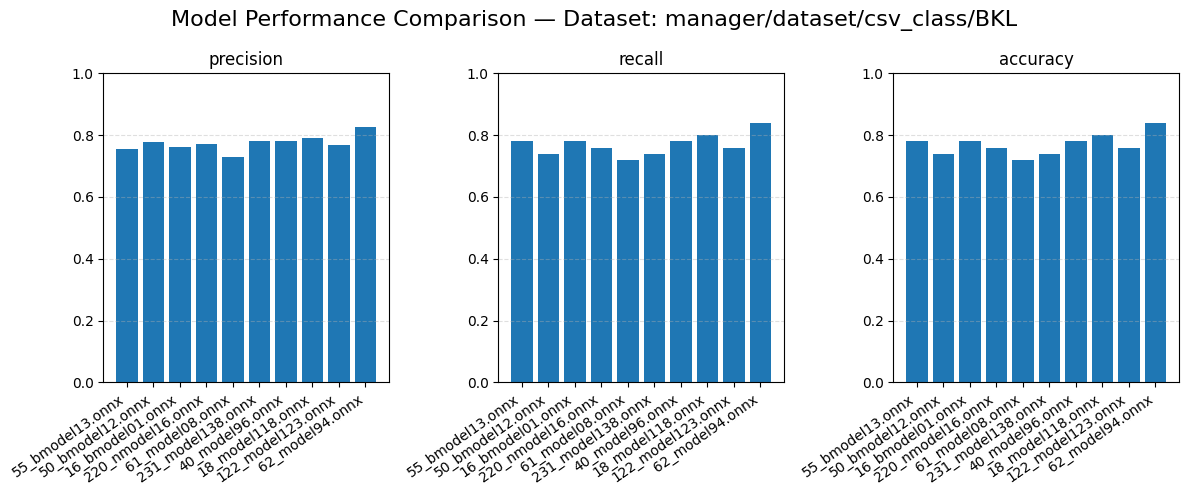

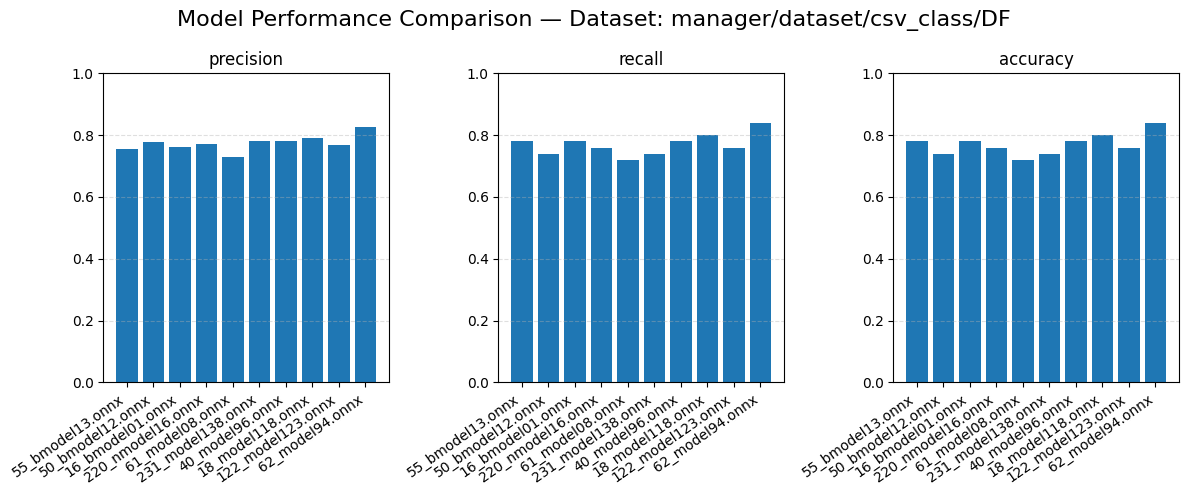

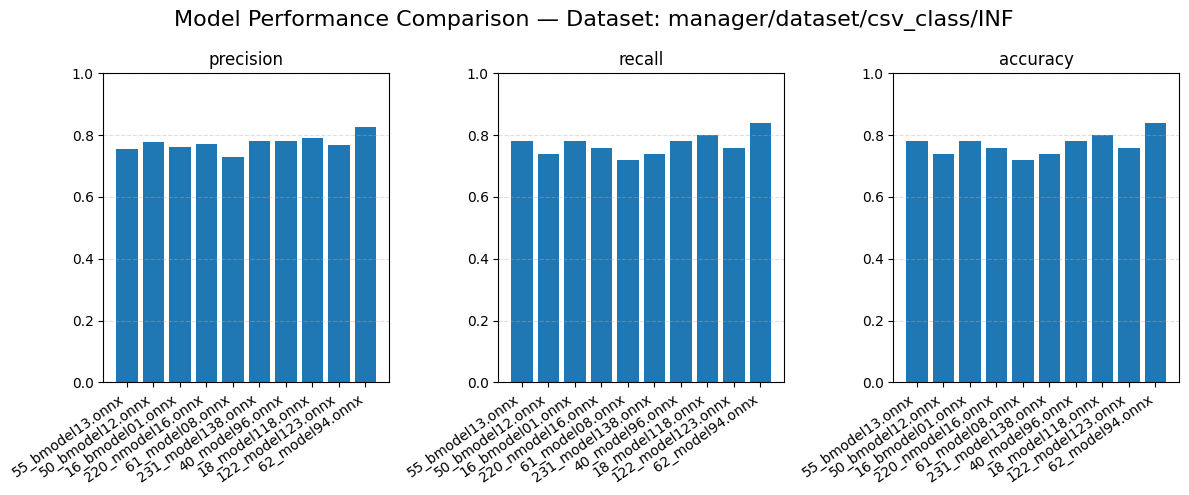

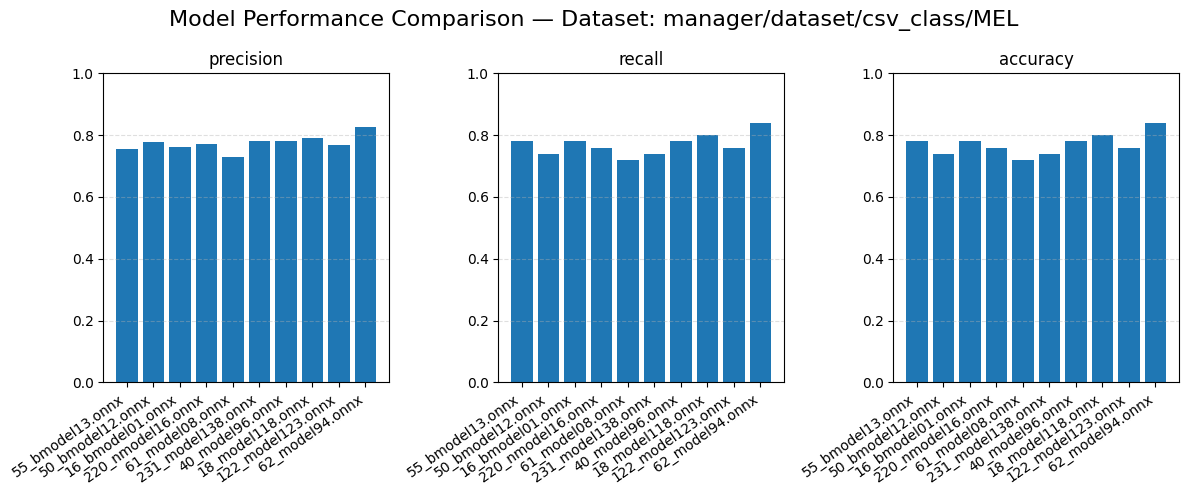

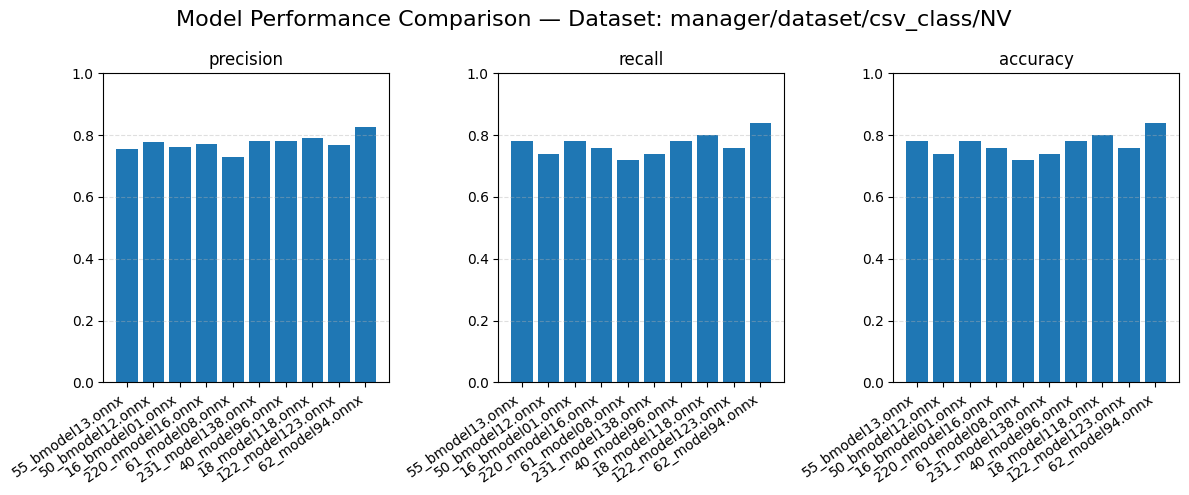

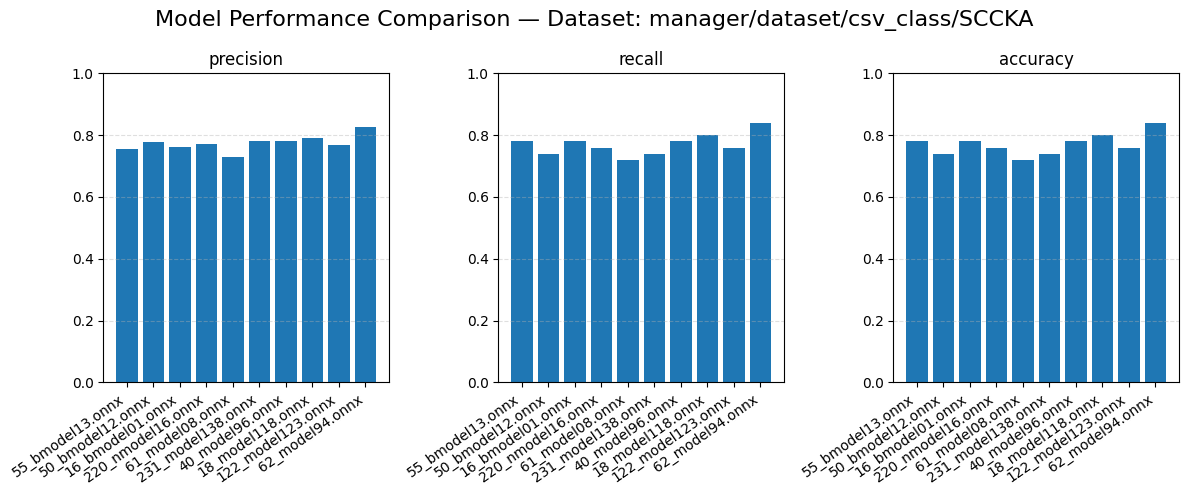

In [23]:
metrics = ["precision", "recall", "accuracy"]

datasets = df["dataset"].unique()

# ------------------------------------------
# Create figure per dataset
# ------------------------------------------
for d in datasets:
    subset = df[df["dataset"] == d]
    models = subset["model"].tolist()

    num_metrics = len(metrics)
    fig, axes = plt.subplots(1, num_metrics, figsize=(4 * num_metrics, 5))
    fig.suptitle(f"Model Performance Comparison — Dataset: {d}", fontsize=16)

    # Handle case of 1 metric (axes wouldn't be a list)
    if num_metrics == 1:
        axes = [axes]

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        values = subset[metric].values
        x = np.arange(len(models))

        ax.bar(x, values)
        ax.set_title(metric)
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=35, ha="right")
        ax.set_ylim(0, 1)
        ax.grid(axis="y", linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()